<a href="https://www.kaggle.com/code/radimkzl/pytorch-ocr?scriptVersionId=238339281" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---------------

# **<font style="color:Black">Create OCR by PyTorch</font>**
-------------------
-----------------

In [1]:
!pip install python-Levenshtein
!pip install optuna
!pip install optuna-dashboard --quiet
!pip install --upgrade structlog
!pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00


In [2]:
#!pip install tensorboard
!tensorboard --version

2025-05-07 10:23:22.572020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 10:23:22.843122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 10:23:22.933322: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746613414.393132      64 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746613414.393707      64 cuda_executor.cc:1015] succ

In [3]:
import os
import sys
import shutil
import random
import time
import datetime
import math
import re
import string
import getpass
import threading
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageFilter
import numpy as np
import cv2

import logging
import structlog
import json

from typing import Iterator, Tuple

import matplotlib.pyplot as plt
from collections import Counter

from Levenshtein import distance as levenshtein_distance

import random

import torch
import torch.nn as nn
import torch.nn.functional as F  # Add this import
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torch.nn.utils as nn_utils

import optuna
from optuna.trial import Trial
from optuna import visualization 
from optuna_dashboard import run_server

import onnx
import onnxruntime as ort

## **<font style="color:blue">Logger settings</font>**
-------------------

In [4]:
LOGS_DIR = os.path.join("/kaggle","working","logs")
os.makedirs(LOGS_DIR, exist_ok=True)
log_file_path = os.path.join(LOGS_DIR, "train_logs.json")

In [5]:
# Configuration of the main logger
def configure_main_logger():
    structlog.configure(
        processors=[
            structlog.stdlib.add_log_level,
            structlog.stdlib.add_logger_name,
            structlog.processors.TimeStamper(fmt="iso"),
            structlog.processors.format_exc_info,
            structlog.processors.JSONRenderer(sort_keys=True),
        ],
        context_class=dict,
        logger_factory=structlog.stdlib.LoggerFactory(),
        wrapper_class=structlog.stdlib.BoundLogger,
    )

configure_main_logger()  # Function call for configuring the main logger

# Configuration Optuna logger
def configure_optuna_logger():
    structlog.configure(
        processors=[
            structlog.stdlib.add_log_level,
            structlog.stdlib.add_logger_name,
            structlog.processors.TimeStamper(fmt="iso"),
            structlog.processors.format_exc_info,
            structlog.processors.JSONRenderer(sort_keys=True),
        ],
        context_class=dict,
        logger_factory=structlog.stdlib.LoggerFactory(),
        wrapper_class=structlog.stdlib.BoundLogger,
    )

configure_optuna_logger()  # Function call for Optuna logger configuration

# Configuration Function logger
def configure_function_logger():
    structlog.configure(
        processors=[
            structlog.stdlib.add_log_level,
            structlog.stdlib.add_logger_name,
            structlog.processors.TimeStamper(fmt="iso"),
            structlog.processors.format_exc_info,
            structlog.processors.JSONRenderer(sort_keys=True),
        ],
        context_class=dict,
        logger_factory=structlog.stdlib.LoggerFactory(),
        wrapper_class=structlog.stdlib.BoundLogger,
    )

configure_function_logger()  # Function call for Optuna logger configuration

# Configuration Final Train logger
def configure_finaltrain_logger():
    """Configures the structlog logger to provide structured JSON logs
    suitable for final train process.

    This function sets up structlog with a predefined set of processors
    to format log messages as JSON. The configuration includes adding
    log level and logger name, timestamping in ISO format, formatting
    exception information, and rendering the final log entry as a sorted
    JSON string.
    """    
    structlog.configure(
        processors=[
            structlog.stdlib.add_log_level,
            structlog.stdlib.add_logger_name,
            structlog.processors.TimeStamper(fmt="iso"),
            structlog.processors.format_exc_info,
            structlog.processors.JSONRenderer(sort_keys=True),
        ],
        context_class=dict,
        logger_factory=structlog.stdlib.LoggerFactory(),
        wrapper_class=structlog.stdlib.BoundLogger,
    )

configure_finaltrain_logger() # Function call for final train logger configuration

In [6]:
# Custom handler for writing logs to JSON file
class RotatingJSONFileHandler(logging.Handler):
    def __init__(self, directory: str, max_bytes: int = 10*1024*1024, backup_count: int = 5, buffer_size: int = 100):
        """
        Inicializuje handler pre rotujúce JSON logy s bufferovaním.

        Args:
            directory (str): Adresár, kam sa ukladajú log súbory.
            max_bytes (int): Maximálna veľkosť súboru pred rotáciou (default: 10 MB).
            backup_count (int): Počet záložných súborov (default: 5).
            buffer_size (int): Veľkosť bufferu pred zápisom na disk (default: 100 záznamov).
        """
        super().__init__()
        self.directory = directory
        self.max_bytes = max_bytes
        self.backup_count = backup_count
        self.buffer_size = buffer_size
        self.buffer = []  # Buffer pre log záznamy
        self.filename = self._get_filename()
        self.file = open(self.filename, "a", encoding="utf-8")
        os.makedirs(directory, exist_ok=True)  # Zabezpečí vytvorenie adresára

    def _get_filename(self) -> str:
        """Vygeneruje názov súboru s časovou pečiatkou."""
        timestamp = time.strftime("%Y%m%d%H%M%S")
        return os.path.join(self.directory, f"train_{timestamp}.json")

    def _should_rotate(self) -> bool:
        """Skontroluje, či je potrebná rotácia súboru na základe jeho veľkosti."""
        self.file.flush()
        try:
            return os.path.getsize(self.filename) > self.max_bytes
        except OSError:
            return False  # Ak súbor neexistuje alebo nie je dostupný, nerotujeme

    def _do_rotate(self) -> None:
        """Vykoná rotáciu súborov."""
        self.file.close()
        base_name = self.filename.split('.')[0]
        
        # Posun starých súborov (napr. train_xxx_1.json -> train_xxx_2.json)
        for i in range(self.backup_count - 1, 0, -1):
            old_file = f"{base_name}_{i}.json"
            new_file = f"{base_name}_{i+1}.json"
            if os.path.exists(old_file):
                os.rename(old_file, new_file)
        
        # Premenovanie aktuálneho súboru na _1
        if os.path.exists(self.filename):
            os.rename(self.filename, f"{base_name}_1.json")
        
        self.filename = self._get_filename()
        self.file = open(self.filename, "a", encoding="utf-8")

    def emit(self, record: logging.LogRecord) -> None:
        """
        Spracuje log záznam a pridá ho do bufferu. Ak je buffer plný alebo je záznam kritický,
        zapíše buffer na disk.
        """
        try:
            log_entry = self._format_record(record)
            self.buffer.append(log_entry + "\n")

            # Zápis bufferu na disk, ak je plný alebo ide o varovanie/chybu
            if len(self.buffer) >= self.buffer_size or record.levelno >= logging.WARNING:
                self._flush_buffer()

        except Exception as e:
            print(f"Error in RotatingJSONFileHandler.emit: {e}")

    def _format_record(self, record: logging.LogRecord) -> str:
        """Formátuje log záznam do JSON reťazca."""
        try:
            # Pokúsi sa parsovať správu ako JSON, ak už je v správnom formáte
            log_entry = record.getMessage()
            json.loads(log_entry)
            return log_entry
        except json.JSONDecodeError:
            # Ak nie je JSON, vytvorí štruktúrovaný JSON záznam
            return json.dumps({
                "timestamp": record.created,
                "level": record.levelname,
                "logger": record.name,
                "message": str(record.msg),
                "args": record.args if record.args else None,
                "exc_info": str(record.exc_info) if record.exc_info else None
            }, ensure_ascii=False)

    def _flush_buffer(self) -> None:
        """Zapíše obsah bufferu na disk a vyprázdni ho."""
        if not self.buffer:
            return
        
        if self._should_rotate():
            self._do_rotate()

        try:
            self.file.writelines(self.buffer)
            self.file.flush()
        except IOError as e:
            print(f"Error writing to file {self.filename}: {e}")
        
        self.buffer = []

    def close(self) -> None:
        """Zatvorí handler a zapíše zvyšný buffer."""
        self._flush_buffer()
        self.file.close()
        super().close()

In [7]:
# Create the main logger
main_logger = structlog.get_logger("mainlog")

# Creating an Optuna logger
optuna_logger = structlog.get_logger("optunalog")

# Creating an Function logger
function_logger = structlog.get_logger("functionlog")

# Creating an Final Train logger
finaltrain_logger = structlog.get_logger("finaltrainlog")

# Set levels for each logger
logging.getLogger("mainlog").setLevel(logging.DEBUG) # main_logger
logging.getLogger("optunalog").setLevel(logging.DEBUG) # optuna_logger
logging.getLogger("functionlog").setLevel(logging.DEBUG) # function_logger
logging.getLogger("finaltrainlog").setLevel(logging.DEBUG) # finaltrain_logger

# Creating a RotatingJSONFileHandler
rotating_json_file_handler = RotatingJSONFileHandler(directory=LOGS_DIR, max_bytes=10*1024*1024, backup_count=5, buffer_size=50)

# Adding RotatingJSONFileHandler to the root logger
logging.getLogger().addHandler(rotating_json_file_handler)

In [8]:
main_logger.info('Star process of notebook.')

## **<font style="color:blue">Hyperparameters</font>**
-------------------

In [9]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [10]:
FINAL_TRAINING = False  # Set to True for final training, False for Optuna optimization
OUTPUT_DIR = os.path.join('/kaggle','working','synthetic_data','images')
TENSORBOARD_DIR = os.path.join('/kaggle','working','runs')
OPTUNA_DIR = os.path.join('/kaggle','working','optuna')
MODEL_DIR = os.path.join('/kaggle','working','model_dir')
LABELS_FILE = os.path.join('/kaggle','working','synthetic_data','labels.txt')
NUM_SAMPLES = 10240  # Number of images generated
IMG_WIDTH = 128
IMG_HEIGHT = 32
BATCH_SIZE = 32
EPOCHS = 5
FINAL_EPOCHS = 90
LEARNING_RATE = 2.9210796294430883e-08
WEIGHT_DECAY =  0.06890033310921728
WARMUP_STEPS = 1281
TEMPERATURE =  0.5819334837385648
CTC_ENTROPY_WEIGHT = 0.7389787176593686
CTC_LABEL_SMOOTHING = 0.1634267600467963
CTC_BLANK_PENALTY_WEIGHT = 0.22532712108152603
BSD_BEAM_WIDTH = 14
BSD_BLANK_PENALTY =  -0.13962503566585263
BSD_LENGTH_PENALTY = -0.18281736078035277
GRADIENT_CLIPPING_VALUE = 7.487796833161923
MAX_SEQ_LENGTH = None
CHARSET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789- "  # Characters used in license plates
FONT_DIR = os.path.join('/kaggle','input','google-fonts','GoogleFontScripts') # Folder with TrueType fonts (.ttf)
BACKGROUND_DIR = os.path.join('/kaggle','working','backgrounds')  # New folder for background (optional)
NUMBER_BACKGROUND_IMAGE = 4000
NUMBER_OF_OPTUNA_TRIALS = 3
GRADIENT_NORM_TRESHOLD = 195
NUMBER_OF_BATCH_REPORT = 20

In [11]:
main_logger.info('Set Base hyperparameters.')

## **<font style="color:blue">Utils support functions</font>**
-------------------

### **<font style="color:green">Create output folders</font>**

In [12]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(BACKGROUND_DIR, exist_ok=True)
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
os.makedirs(OPTUNA_DIR, exist_ok=True)

# Creates a new file
with open(LABELS_FILE, 'w') as fp:
    pass

In [13]:
main_logger.info('Create dirs structure.')

### **<font style="color:green">Load the font list (add the paths to the .ttf files to the "fonts" folder)</font>**

In [14]:
font_files = [
    os.path.join(FONT_DIR, f) for f in os.listdir(FONT_DIR) 
    if f.endswith('.ttf') and os.path.isfile(os.path.join(FONT_DIR, f))
]
if not font_files:
    raise FileNotFoundError("No fonts found in 'fonts' folder. Add .ttf files!")
    main_logger.error("No fonts found in 'fonts' folder. Add .ttf files!")

In [15]:
main_logger.info('Load google-fonts files from dataset.')

### **<font style="color:green">Generating a simple gradient background</font>**

In [16]:
def generate_gradient_background(filename, size=(128, 32)):
    """
    Generates a gradient background image and saves it to a specified file.

    This function creates a grayscale image with a soft gradient effect, where the color transitions
    from a lighter gray at the top to a slightly darker gray at the bottom. The image is then blurred
    to create a smooth background effect.

    Args:
        filename (str): The name of the file where the generated image will be saved.
        size (tuple, optional): The dimensions (width, height) of the generated image. Defaults to (128, 32).

    The function uses the Python Imaging Library (PIL) to create and manipulate the image.
    """
    img = Image.new('L', size, color=230)  # Lighter gray as a base
    draw = ImageDraw.Draw(img)
    for y in range(size[1]):
        # Soft gradient with low contrast
        color = int(230 - 20 * (y / size[1]))  # From light gray to slightly darker
        draw.line([(0, y), (size[0], y)], fill=color)
    # Background blur
    img = img.filter(ImageFilter.GaussianBlur(radius=2))
    img.save(os.path.join(BACKGROUND_DIR, filename))

### **<font style="color:green">Generate a background with noise (paper texture)</font>**

In [17]:
def generate_paper_texture(filename, size=(128, 32)):
    img = Image.new('L', size, color=220)  # Lighter gray
    noise = np.random.normal(0, 5, size).astype(np.uint8)  # Less noise
    noise_img = Image.fromarray(noise)
    img.paste(noise_img, (0, 0), noise_img)
    # Blur for a softer effect
    img = img.filter(ImageFilter.GaussianBlur(radius=1.5))
    img.save(os.path.join(BACKGROUND_DIR, filename))

### **<font style="color:green">Creating multiple backgrounds</font>**

In [18]:
for i in range(NUMBER_BACKGROUND_IMAGE):
    generate_gradient_background(f"gradient_{i}.png")
    generate_paper_texture(f"paper_{i}.png")

In [19]:
main_logger.info('Background images was generated.')

### **<font style="color:green">Load backgrounds (optional, add images to the "backgrounds" folder)</font>**

In [20]:
background_files = (
    [os.path.join(BACKGROUND_DIR, f) for f in os.listdir(BACKGROUND_DIR) 
     if f.endswith(('.png', '.jpg', '.jpeg'))] if os.path.exists(BACKGROUND_DIR) else []
)

In [21]:
main_logger.info('Background images was loaded for useing.')

### **<font style="color:green">List of setting type of formats</font>**

In [22]:
formats = {
    "Czech Republic": [
        {
            "regex": r"[A-Z]\d[A-Z]{5}",
            "description": "One letter, one digit, five letters",
            "weight": 0.95  # Kept the same
        },
        {
            "regex": r"[A-Z]\d-[A-Z]{5}",
            "description": "One letter, one digit, dash, five letters",
            "weight": 0.05  # Kept the same
        }
    ],
    "Germany": [
        {
            "regex": r"[A-Z]-[A-Z]{2} \d{3}",
            "description": "One letter, dash, two letters, space, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce space and dash frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.15  # Increased from 0.1 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.7  # Kept the same
        }
    ],
    "France": [
        {
            "regex": r"[A-Z]{2}-\d{3}-[A-Z]{2}",
            "description": "Two letters, dash, three digits, dash, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{2} \d{3} [A-Z]{2}",
            "description": "Two letters, space, three digits, space, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{2}\d{3}[A-Z]{2}",
            "description": "Two letters, three digits, two letters",
            "weight": 0.15  # Increased from 0.1 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.45  # Kept the same
        }
    ],
    "United Kingdom": [
        {
            "regex": r"[A-Z]{2}\d{2} [A-Z]{3}",
            "description": "Two letters, two digits, space, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{2}\d{2}[A-Z]{3}",
            "description": "Two letters, two digits, three letters",
            "weight": 0.15  # Increased from 0.1 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{1}",
            "description": "Four letters, one digit",
            "weight": 0.7  # Kept the same
        }
    ],
    "Brazil": [
        {
            "regex": r"\d{3}[A-Z]{4}",
            "description": "Three digits, four letters",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{3}-\d{2}-[A-Z]{2}",
            "description": "Three letters, dash, two digits, dash, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.4  # Reduced from 0.45 to balance overall distribution
        }
    ],
    "Australia": [
        {
            "regex": r"[A-Z]{3}-\d{3}",
            "description": "Three letters, dash, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{3} \d{3}",
            "description": "Three letters, space, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.6  # Increased from 0.55 to maintain letter frequency
        }
    ],
    "Austria": [
        {
            "regex": r"\d[A-Z]{4}\d{2}",
            "description": "One digit, four letters, two digits",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.5  # Kept the same
        },
        {
            "regex": r"\d-[A-Z]{4}-\d{2}",
            "description": "One digit, dash, four letters, dash, two digits",
            "weight": 0.05  # Reduced from 0.1 to reduce dash frequency
        },
        {
            "regex": r"\d [A-Z]{4} \d{2}",
            "description": "One digit, space, four letters, space, two digits",
            "weight": 0.1  # Kept the same
        }
    ],
    "Italy": [
        {
            "regex": r"[A-Z]{2} \d{3}[A-Z]{2}",
            "description": "Two letters, space, three digits, space, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{2}-\d{3}[A-Z]{2}",
            "description": "Two letters, dash, three digits, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{2}\d{3}[A-Z]{2}",
            "description": "Two letters, three digits, two letters",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.5  # Kept the same
        }
    ],
    "Belgium": [
        {
            "regex": r"\d-[A-Z]{3}-\d{3}",
            "description": "One digit, dash, three letters, dash, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.55  # Kept the same
        },
        {
            "regex": r"[A-Z] \d{3} [A-Z]{3}",
            "description": "One letter, space, three digits, space, three letters",
            "weight": 0.2  # Kept the same
        }
    ],
    "Spain": [
        {
            "regex": r"[A-Z]{4}\d{3}",
            "description": "Four letters, three digits",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}-\d{2}-[A-Z]",
            "description": "Four letters, dash, two digits, dash, one letter",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.4  # Kept the same
        },
        {
            "regex": r"[A-Z]{4} \d{2} [A-Z]",
            "description": "Four letters, space, two digits, space, one letter",
            "weight": 0.1  # Kept the same
        }
    ],
    "Hungary": [
        {
            "regex": r"[A-Z] \d{2} [A-Z]{3}",
            "description": "One letter, space, two digits, space, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]\d{2}[A-Z]{3}",
            "description": "One letter, two digits, three letters",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{1}",
            "description": "Four letters, one digit",
            "weight": 0.65  # Kept the same
        },
        {
            "regex": r"[A-Z]\d-[A-Z]{3}-\d",
            "description": "One letter, one digit, dash, three letters, dash, one digit",
            "weight": 0.1  # Kept the same
        }
    ],
    "Norway": [
        {
            "regex": r"\d{2}[A-Z]{5}",
            "description": "Two digits, five letters",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{2}-\d{2}-[A-Z]{3}",
            "description": "Two letters, dash, two digits, dash, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{2} \d{2} [A-Z]{3}",
            "description": "Two letters, space, two digits, space, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.35  # Increased from 0.3 to maintain letter frequency
        }
    ],
    "Sweden": [
        {
            "regex": r"[A-Z]{3} \d{3}",
            "description": "Three letters, space, three digits",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.75  # Kept the same
        }
    ],
    "Netherlands": [
        {
            "regex": r"[A-Z]{2}-\d{2}-[A-Z]{2}",
            "description": "Two letters, dash, two digits, dash, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"[A-Z]{2}\d{2}[A-Z]{2}",
            "description": "Two letters, two digits, two letters",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{1}",
            "description": "Four letters, one digit",
            "weight": 0.55  # Kept the same
        },
        {
            "regex": r"[A-Z]{2} \d{2} [A-Z]{2}",
            "description": "Two letters, space, two digits, space, two letters",
            "weight": 0.2  # Reduced from 0.2 to maintain balance
        }
    ],
    "Serbia": [
        {
            "regex": r"[A-Z]{2} \d{3}-[A-Z]{2}",
            "description": "Two letters, space, three digits, dash, two letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space and dash frequency
        },
        {
            "regex": r"[A-Z]{2}\d{3}[A-Z]{2}",
            "description": "Two letters, three digits, two letters",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.05  # Kept the same
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.7  # Kept the same
        }
    ],
    "Ukraine": [
        {
            "regex": r"\d{2}[A-Z]{4}\d{2}",
            "description": "Two digits, four letters, two digits",
            "weight": 0.35  # Increased from 0.3 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.5  # Kept the same
        },
        {
            "regex": r"\d{2}-[A-Z]{4}-\d",
            "description": "Two digits, dash, four letters, dash, one digit",
            "weight": 0.05  # Reduced from 0.1 to reduce dash frequency
        },
        {
            "regex": r"\d{2} [A-Z]{4} \d",
            "description": "Two digits, space, four letters, space, one digit",
            "weight": 0.1  # Kept the same
        }
    ],
    "USA_v1": [
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.9  # Reduced from 0.95 to balance overall distribution
        }
    ],
    "USA_v2": [
        {
            "regex": r"\d{3}-[A-Z]{3}",
            "description": "Three digits, dash, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce dash frequency
        },
        {
            "regex": r"\d{3} [A-Z]{3}",
            "description": "Three digits, space, three letters",
            "weight": 0.15  # Reduced from 0.2 to reduce space frequency
        },
        {
            "regex": r"[A-Z]{4}\d{2}",
            "description": "Four letters, two digits",
            "weight": 0.1  # Increased from 0.05 to boost digit frequency
        },
        {
            "regex": r"[A-Z]{5}\d{1}",
            "description": "Five letters, one digit",
            "weight": 0.6  # Increased from 0.55 to maintain letter frequency
        }
    ]
}

### **<font style="color:green">Random text generation function</font>**

In [23]:
def generate_random_license_plate_from_regex(regex_format):
    license_plate = ""
    i = 0
    
    while i < len(regex_format):
        char = regex_format[i]

        # Handle escaped sequences like \d or \w
        if char == '\\' and i + 1 < len(regex_format):
            next_char = regex_format[i + 1]
            repeat = 1
            i += 2  # Skip backslash and the next character

            # Check for repetition pattern {n}
            if i < len(regex_format) and regex_format[i] == '{':
                match = re.match(r"\{(\d+)\}", regex_format[i:])
                if match:
                    repeat = int(match.group(1))
                    i += len(match.group(0))  # Skip {n}

            if next_char == 'd':
                license_plate += ''.join(random.choice(string.digits) for _ in range(repeat))
            elif next_char == 'w':
                license_plate += ''.join(random.choice(string.ascii_uppercase) for _ in range(repeat))
            else:
                license_plate += next_char  # Treat as literal if not \d or \w

        # Handle character classes like [A-Z] or [0-9]
        elif char == '[':
            j = regex_format.find(']', i)
            if j != -1:
                options = regex_format[i+1:j]
                i = j + 1  # Move past ]

                repeat = 1
                if i < len(regex_format) and regex_format[i] == '{':
                    match = re.match(r"\{(\d+)\}", regex_format[i:])
                    if match:
                        repeat = int(match.group(1))
                        i += len(match.group(0))  # Skip {n}

                if options == 'A-Z':
                    license_plate += ''.join(random.choice(string.ascii_uppercase) for _ in range(repeat))
                elif options == '0-9':
                    license_plate += ''.join(random.choice(string.digits) for _ in range(repeat))
                else:
                    license_plate += ''.join(random.choice(options) for _ in range(repeat))
            else:
                license_plate += char  # Unmatched [, treat as literal

        # Handle literal characters (e.g., space, dash)
        else:
            license_plate += char
            i += 1

    return license_plate

In [24]:
def generate_random_license_plate(formats):
    # Choose a random country
    country = random.choice(list(formats.keys()))
    country_formats = formats[country]

    # If the format is a list (multiple options), select by weight
    if isinstance(country_formats, list):
        weights = [fmt["weight"] for fmt in country_formats]
        chosen_format = random.choices(country_formats, weights=weights, k=1)[0]
        regex_format = chosen_format["regex"]
    else:
        regex_format = country_formats["regex"]

    # Generate license plate according to selected regex
    license_plate = generate_random_license_plate_from_regex(regex_format)
    return license_plate, country

In [25]:
# Test code
for _ in range(10):
    license_plate, country = generate_random_license_plate(formats)
    print(f"Country: {country}, License Plate: {license_plate}")
    main_logger.debug(f'Testing generation of Licence Plate text\n: Country: {country}, License Plate: {license_plate}\n')

Country: Italy, License Plate: ELTPU9
Country: France, License Plate: PIRHG7
Country: USA_v2, License Plate: PMUEH2
Country: USA_v1, License Plate: AVYCF9
Country: Germany, License Plate: AIPTX6
Country: Netherlands, License Plate: ZSOE5
Country: United Kingdom, License Plate: PG46 YUJ
Country: Netherlands, License Plate: MSLR9
Country: Netherlands, License Plate: KVAI9
Country: Australia, License Plate: KRSSD3


### **<font style="color:green">Function for clean labels of file</font>**
- Open labels.txt and ensure that all labels only contain characters from CHARSET. If there are any invalid characters, clean the file:

In [26]:
def clean_labels_file(labels_file, valid_chars):
    """
    Cleans the labels file by removing invalid characters from each label.

    Args:
        labels_file (str): Path to the labels file.
        valid_chars (set): Set of valid characters allowed in labels.
    """
    with open(labels_file, 'r') as f:
        lines = f.readlines()
    
    cleaned_lines = []
    num_modified = 0
    num_removed = 0
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) != 2:
            num_removed += 1
            continue
        img_path, label = parts
        cleaned_label = ''.join(c for c in label if c in valid_chars)
        if cleaned_label:  # Only keep non-empty labels
            if cleaned_label != label:
                num_modified += 1
            cleaned_lines.append(f"{img_path}\t{cleaned_label}\n")
        else:
            num_removed += 1
    
    with open(labels_file, 'w') as f:
        f.writelines(cleaned_lines)
    
    print(f"Cleaned {labels_file}: {num_modified} labels modified, {num_removed} labels removed.")
    function_logger.info(f"Cleaned {labels_file}: {num_modified} labels modified, {num_removed} labels removed.")

### **<font style="color:green">Functions for adding noise and distortions</font>**

In [27]:
def add_noise_and_distortion(img):
    """
    Adds random noise and distortion effects to an input image.

    This function takes an image as input and applies random Gaussian noise, rotation, and perspective distortion to simulate real-world imperfections. 
    The modifications are applied randomly to create variability in the output.

    Args:
        img (PIL.Image.Image): The input image to which noise and distortion will be applied.

    Returns:
        PIL.Image.Image: The modified image with added noise and distortion effects.

    The function uses NumPy for array manipulations and OpenCV for image transformations.
    """
    img_array = np.array(img)

    # Add Gaussian noise
    if random.random() > 0.5:
        noise = np.random.normal(0, random.randint(10, 25), img_array.shape).astype(np.uint8)
        img_array = cv2.add(img_array, noise)

    # Apply rotation
    angle = random.uniform(-5, 5)
    rows, cols = img_array.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    img_array = cv2.warpAffine(img_array, M, (cols, rows))

    # Apply perspective distortion
    src_points = np.float32([[0, 0], [cols-1, 0], [0, rows-1], [cols-1, rows-1]])
    dst_points = np.float32([
        [random.uniform(0, 5), random.uniform(0, 5)],
        [cols-1-random.uniform(0, 5), random.uniform(0, 5)],
        [random.uniform(0, 5), rows-1-random.uniform(0, 5)],
        [cols-1-random.uniform(0, 5), rows-1-random.uniform(0, 5)]
    ])
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    img_array = cv2.warpPerspective(img_array, matrix, (cols, rows))

    return Image.fromarray(img_array)

### **<font style="color:green">Improved image generation feature</font>**

In [28]:
def generate_synthetic_image(text, font_path, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    """
    Generates a synthetic image with specified text and font, optionally using a background image.

    This function creates an image with a given text rendered using a specified font. 
    The image can have a background selected from available background files or a generated gradient background. 
    The text is positioned randomly within the image, and the function ensures that the text fits within the image dimensions by adjusting the font size or shortening the text if necessary. 
    The image is then modified with noise and distortion effects to simulate real-world conditions.

    Args:
        text (str): The text to be rendered on the image.
        font_path (str): The file path to the TrueType font to be used for rendering the text.
        img_size (tuple, optional): The dimensions (width, height) of the generated image. Defaults to (IMG_WIDTH, IMG_HEIGHT).

    Returns:
        PIL.Image.Image: The generated synthetic image with the specified text and effects.

    The function uses the Python Imaging Library (PIL) for image creation and manipulation, and it relies on the `add_noise_and_distortion` function to apply additional effects to the image.
    """
    # Background
    if background_files:
        bg_path = random.choice(background_files)
        img = Image.open(bg_path).convert('L').resize(img_size)
    else:
        img = Image.new('L', img_size, color=230)
        draw = ImageDraw.Draw(img)
        for y in range(img_size[1]):
            color = int(230 - 20 * (y / img_size[1]))
            draw.line([(0, y), (img_size[0], y)], fill=color)
        img = img.filter(ImageFilter.GaussianBlur(radius=2))

    draw = ImageDraw.Draw(img)

    # Iterative font and text editing
    font_size = random.randint(20, min(IMG_HEIGHT-2, 28))
    max_attempts = 5  # Limiting the number of attempts
    for attempt in range(max_attempts):
        font = ImageFont.truetype(font_path, font_size)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

        if text_width <= IMG_WIDTH - 10:  # Text will fit
            break
        elif len(text) > 1:  # Shorten the text if it is too long.
            text = text[:len(text)//2]
        else:  # Reduce font size
            font_size = max(10, font_size - 5)  # Minimum size 10

    # If that doesn't work, use a minimal font and single-letter text.
    if text_width > IMG_WIDTH - 10:
        text = text[0]  # Use the first letter
        font_size = 10
        font = ImageFont.truetype(font_path, font_size)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

    # Text position
    x = random.randint(5, max(5, IMG_WIDTH - text_width - 5))
    y = random.randint(5, max(5, IMG_HEIGHT - text_height - 5))

    # Highlighting text
    text_color = random.randint(0, 50)
    outline_color = 200
    for offset_x in [-1, 0, 1]:
        for offset_y in [-1, 0, 1]:
            if offset_x != 0 or offset_y != 0:
                draw.text((x + offset_x, y + offset_y), text, font=font, fill=outline_color)
    draw.text((x, y), text, font=font, fill=text_color)

    # Noise and distortion
    img = add_noise_and_distortion(img)
    return img

### **<font style="color:green">Function for splitting labels</font>**

In [29]:
def split_labels(labels, label_lengths):
    """
    Splits a sequence of labels into sub-sequences based on specified lengths.
    
    This function takes a single concatenated sequence of labels and splits it into multiple sub-sequences. 
    The lengths of these sub-sequences are specified by the `label_lengths` parameter. 
    Each sub-sequence is extracted from the `labels` sequence and appended to a list, which is then returned.
    
    Args:
        labels (str or list): The concatenated sequence of labels to be split. This can be a string or a list of characters/elements.
        label_lengths (list of int): A list of integers where each integer specifies the length of a corresponding sub-sequence to be extracted from `labels`.
    
    Returns:
        list: A list of sub-sequences extracted from `labels` according to the specified lengths in `label_lengths`.
    
    Example:
        >>> split_labels("abcdefgh", [2, 3, 3])
        ['ab', 'cde', 'fgh']
    """
    split_labels = []
    start = 0
    for length in label_lengths:
        split_labels.append(labels[start:start + length])
        start += length
    return split_labels

### **<font style="color:green">Function of Beam search decoding</font>**

In [30]:
def beam_search_decode(output, idx_to_char, target_lengths, beam_width=5, blank_penalty=0.1, length_penalty=0.1, global_step=0):
    """
    Performs beam search decoding on the model's output logits.

    Args:
        output (torch.Tensor): Model output logits, shape (T, B, C).
        idx_to_char (dict): Mapping from indices to characters.
        target_lengths (torch.Tensor): Target label lengths for each batch.
        beam_width (int): Number of beams to keep during search.
        blank_penalty (float): Penalty for blank token.
        length_penalty (float): Penalty for sequence length.
        global_step (int): Global step for logging purposes.

    Returns:
        list: List of decoded strings for each batch.
    """
    T, B, C = output.shape
    output = output.softmax(2)  # Convert logits to probabilities

    decoded_texts = []
    for b in range(B):
        # Get the probabilities for this batch
        probs = output[:, b, :]  # (T, C)

        # Initialize the beam with an empty sequence
        beams = [([], 0.0)]  # (sequence, log_prob)

        # For each time step
        for t in range(T):
            new_beams = []
            for seq, log_prob in beams:
                # For each possible character
                for c in range(C):
                    prob = probs[t, c].item()
                    if prob < 1e-10:  # Avoid log(0)
                        continue
                    new_log_prob = log_prob + math.log(prob)

                    # Apply blank penalty
                    if c == 0:  # Blank token
                        new_log_prob += blank_penalty

                    new_seq = seq + [c]
                    new_beams.append((new_seq, new_log_prob))

            # Keep the top beam_width sequences
            new_beams.sort(key=lambda x: x[1], reverse=True)
            beams = new_beams[:beam_width]

        # Apply length penalty to the final beams
        beams = [(seq, log_prob + length_penalty * len(seq)) for seq, log_prob in beams]
        beams.sort(key=lambda x: x[1], reverse=True)
        best_seq = beams[0][0]  # Best sequence

        # Convert indices to characters, skipping blanks and duplicates
        decoded = []
        prev_char = None
        for idx in best_seq:
            if idx == 0:  # Skip blank token
                continue
            char = idx_to_char.get(idx, '')
            if char and char != prev_char:  # Skip duplicates
                decoded.append(char)
            prev_char = char

        decoded_text = ''.join(decoded)
        decoded_texts.append(decoded_text)

    return decoded_texts

### **<font style="color:green">Custom collate function</font>**

In [31]:
def custom_collate_fn(batch):
    """
    Custom collate function for combining a batch of data samples into a single batch.

    This function is used to process a batch of data samples, typically for use in a data loader during model training or evaluation. It stacks images, concatenates labels, and converts label lengths into tensors, preparing the data for efficient processing in a neural network.

    Args:
        batch (list of tuples): A list where each element is a tuple containing:
            - An image tensor.
            - A label tensor.
            - An integer representing the length of the label.

    Returns:
        tuple: A tuple containing:
            - images (torch.Tensor): A tensor of stacked images from the batch.
            - labels (torch.Tensor): A concatenated tensor of labels from the batch.
            - label_lengths (torch.Tensor): A tensor of label lengths from the batch.

    The function ensures that the images, labels, and label lengths are properly formatted as tensors, making them compatible with PyTorch operations.
    """
    images, labels, label_lengths = zip(*batch)
    # Stack images (all same size)
    images = torch.stack(images, dim=0)
    # Concatenate labels into a flat tensor
    labels = torch.cat(labels, dim=0)
    # Convert label_lengths to tensor
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)
    return images, labels, label_lengths

### **<font style="color:green">Analyze dataset char frequency</font>**

In [32]:
def analyze_dataset_char_frequency(labels_file, charset):
    """
    Analyzes the character frequency in the generated dataset and displays a progress bar.
    
    Args:
        labels_file (str): Path to the labels file (e.g., LABELS_FILE).
        charset (str): String containing all possible characters (e.g., CHARSET).
    
    Returns:
        dict: Dictionary with character frequencies.
    """
    if not os.path.exists(labels_file):
        print(f"Error: Labels file '{labels_file}' does not exist!")
        function_logger.error(f"Error: Labels file '{labels_file}' does not exist!")
        return {}

    # Read labels and extract texts
    with open(labels_file, 'r') as f:
        labels = [line.split('\t')[1].strip() for line in f if '\t' in line]

    if not labels:
        print("Error: No valid labels found in the file!")
        return {}

    # Count character frequencies
    all_chars = ''.join(labels)
    char_counts = Counter(all_chars)

    # Prepare data for the bar plot
    chars = list(charset)
    frequencies = [char_counts.get(char, 0) for char in chars]

    # Create a progress bar (bar plot)
    plt.figure(figsize=(12, 6))
    plt.bar(chars, frequencies, color='skyblue')
    plt.xlabel('Characters')
    plt.ylabel('Frequency')
    plt.title('Character Frequency in Dataset')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Print summary
    total_chars = sum(frequencies)
    print(f"Total characters analyzed: {total_chars}")
    print("Character frequencies:", dict(char_counts))
    function_logger.debug(f"Total characters analyzed: {total_chars}")
    function_logger.debug(f"Character frequencies: {dict(char_counts)}")

    return dict(char_counts)

### **<font style="color:green">Generating a data file</font>**

In [33]:
def create_synthetic_dataset(num_samples):
    """
    Creates a synthetic dataset with images and corresponding labels.
    
    Args:
        num_samples (int): Number of images to generate.
    
    Notes:
        It uses global variables: OUTPUT_DIR, LABELS_FILE, font_files, MAX_TEXT_LENGTH, MIN_TEXT_LENGTH, CHARSET.
        It assumes the existence of the generate_synthetic_image and generate_random_license_plate functions,
        and access to font_files.
    """
    # Ensure OUTPUT_DIR exists
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Created directory: {OUTPUT_DIR}")
        function_logger.info(f"Created directory: {OUTPUT_DIR}")

    # Define valid characters based on CHARSET
    valid_chars = set(CHARSET)  # CHARSET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789- "
    
    labels = []
    for i in range(num_samples):
        # Generate text for a license plate
        text, country = generate_random_license_plate(formats)
        if not text:
            function_logger.warning(f"Skipping sample {i}: Empty text generated.")
            continue  # Skip if text is empty

        # Ensure the generated text only contains valid characters
        cleaned_text = ''.join(c for c in text if c in valid_chars)
        if not cleaned_text:
            function_logger.warning(f"Skipping sample {i}: No valid characters in text '{text}'.")
            continue  # Skip if the cleaned text is empty

        # Random font selection
        font_path = random.choice(font_files)
        
        # Image generation
        try:
            img = generate_synthetic_image(cleaned_text, font_path)
            img_name = f"img_{i:05d}.png"
            img_path = os.path.join(OUTPUT_DIR, img_name)
            img.save(img_path)
        except Exception as e:
            function_logger.error(f"Failed to generate image for sample {i} (Text: {cleaned_text}): {str(e)}")
            continue

        # Save the label
        labels.append(f"{img_name}\t{cleaned_text}")
        
        # Progress report
        if i % 100 == 0:
            print(f"Generated {i}/{num_samples} images (Country: {country}, Text: {cleaned_text})")
            function_logger.debug(f"Generated {i}/{num_samples} images (Country: {country}, Text: {cleaned_text})")

    # Save labels to a file
    if labels:
        with open(LABELS_FILE, 'w') as f:
            f.write("\n".join(labels))
        print(f"Labels written to '{LABELS_FILE}' (before cleaning).")
        function_logger.debug(f"Labels written to '{LABELS_FILE}' (before cleaning).")

        # Clean the labels file to ensure no invalid characters remain
        clean_labels_file(LABELS_FILE, valid_chars)

        # Analyze and display character frequency
        analyze_dataset_char_frequency(LABELS_FILE, CHARSET)
        
        print(f"Dataset generated! Images saved in '{OUTPUT_DIR}', labels in '{LABELS_FILE}'")
        function_logger.info(f"Dataset generated! Images saved in '{OUTPUT_DIR}', labels in '{LABELS_FILE}'")
    else:
        print("No labels generated! Check the generate_random_license_plate function or font files.")
        function_logger.error("No labels generated! Check the generate_random_license_plate function or font files.")

## **<font style="color:blue">Mapping characters to indices and back</font>**
-------------------

In [34]:
num_chars = len(CHARSET) + 1

In [35]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # 0 is reserved for blank (CTC)
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [36]:
main_logger.info('Mapping characters to indices and back was done.')

## **<font style="color:blue">Test regex generation</font>**
-------------------

## **<font style="color:blue">Custom dataset</font>**
-------------------

In [37]:
class OCRDataset(Dataset):
    """
    A custom dataset class for Optical Character Recognition (OCR) tasks.

    This class extends PyTorch's Dataset class and is used to load and preprocess images and their corresponding labels for OCR tasks. It reads image paths and labels from a file and provides methods to access the data.

    Args:
        Dataset (torch.utils.data.Dataset): The base dataset class from PyTorch.
    """
    def __init__(self, image_dir, labels_file):
        """
        Initializes the OCRDataset with the directory containing images and the file containing labels.

        Args:
            image_dir (str): The directory path where the images are stored.
            labels_file (str): The file path containing the labels corresponding to the images. The file should have each line formatted as 'image_path\tlabel'.
        """
        self.image_dir = image_dir
        self.labels_file = labels_file
        self.data = []
        with open(labels_file, 'r') as f:
            for line in f:
                if not line.strip():  # Skip empty lines
                    continue
                image_path, label = line.strip().split('\t')
                label_length = len(label)
                self.data.append((image_path, label, label_length))

    def __len__(self):
        """_summary_

        Returns:
            _type_: _description_
        """
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label, label_length = self.data[idx]
        image = Image.open(os.path.join(self.image_dir, image_path)).convert('L')
        image = transforms.ToTensor()(image)
        label_encoded = torch.tensor([char_to_idx[c] for c in label], dtype=torch.long)
        return image, label_encoded, label_length

## **<font style="color:blue">Custom CTC Loss with Blank Penalty</font>**
-------------------
> CTC Loss with Entropy Regularization

In [38]:
class CTCLossWithBlankPenalty(nn.Module):
    """
    A custom loss module that extends the Connectionist Temporal Classification (CTC) loss with additional penalties.

    This class adds penalties for blank predictions and entropy to the standard CTC loss, which is commonly used in sequence-to-sequence tasks like speech recognition and OCR. 
    The penalties help to regularize the model and improve convergence during training.

    Args:
        nn (torch.nn.Module): The base module class from PyTorch.
    """

    def __init__(self, blank=0, zero_infinity=True, blank_penalty_weight=1.0, entropy_weight=0.5, label_smoothing=0.1):
        """
        Initializes the CTCLossWithBlankPenalty with specified parameters.

        Args:
            blank (int, optional): The index of the blank label. Defaults to 0.
            zero_infinity (bool, optional): Whether to zero the loss of sequences with infinite loss. Defaults to True.
            blank_penalty_weight (float, optional): The weight of the blank penalty. Defaults to 1.0.
            entropy_weight (float, optional): The weight of the entropy penalty. Defaults to 0.5.
            label_smoothing (float, optional): The amount of label smoothing to apply. Defaults to 0.1.
        """
        super().__init__()
        self.ctc_loss = nn.CTCLoss(blank=blank, reduction='mean', zero_infinity=zero_infinity)
        self.blank = blank  # Add blank index as an attribute
        self.blank_penalty_weight = blank_penalty_weight
        self.entropy_weight = entropy_weight  
        self.label_smoothing = label_smoothing
        self.global_step = 0

    def update_blank_penalty(self, global_step):
        """
        Updates the blank penalty weight based on the current global step.

        This method gradually reduces the blank penalty weight over the first 1,000 steps to stabilize training.

        Args:
            global_step (int): The current global step or iteration number.
        """
        # Gradual reduction of penalty over the first 1,000 steps
        self.global_step = global_step
        decay_factor = max(0.1, 1.0 - self.global_step / 1000.0)
        self.blank_penalty_weight = 1.0 * decay_factor

    def forward(self, log_probs, targets, input_lengths, target_lengths):
        """
        Computes the total loss, including CTC loss, blank penalty, and entropy penalty.

        Args:
            log_probs (torch.Tensor): The log probabilities output by the model, of shape (T, N, C), 
                                      where T is the input sequence length, N is the batch size, and C is the number of classes.
            targets (torch.Tensor): The target sequences, of shape (N, S), where S is the target sequence length.
            input_lengths (torch.Tensor): The lengths of the input sequences, of shape (N,).
            target_lengths (torch.Tensor): The lengths of the target sequences, of shape (N,).

        Returns:
            torch.Tensor: The total loss, which is the sum of the CTC loss, blank penalty, and entropy penalty.
        """
        # Standard CTC loss
        ctc_loss = self.ctc_loss(log_probs, targets, input_lengths, target_lengths)

        # Blank penalty: penalize high blank probability (updated to be proportional)
        blank_probs = log_probs[:, :, self.blank].exp().mean()
        blank_penalty = self.blank_penalty_weight * blank_probs  # Changed from -torch.log(1 - blank_probs + 1e-4) * self.blank_penalty_weight

        # Entropy regularization
        probs = log_probs.exp()
        entropy = -torch.sum(probs * log_probs, dim=-1).mean()
        entropy_loss = -self.entropy_weight * entropy

        # Total loss
        total_loss = ctc_loss + blank_penalty + entropy_loss
        return total_loss

## **<font style="color:blue">Custom functions of metrics</font>**

### **<font style="color:green">Character Error Rate (CER)</font>**

- Measures the number of character-level errors (insertions, deletions, substitutions) between the predicted text and the ground truth, normalized by the length of the ground truth.

In [39]:
def compute_cer(pred_texts, ground_truth):
    """
    Computes the Character Error Rate (CER) between predicted texts and ground truth.

    Args:
        pred_texts (list of str): List of predicted texts.
        ground_truth (list of str): List of ground truth texts.

    Returns:
        float: Average CER across the batch.
    """
    total_errors = 0
    total_chars = 0
    for pred, gt in zip(pred_texts, ground_truth):
        errors = levenshtein_distance(pred, gt)
        total_errors += errors
        total_chars += len(gt)
    cer = total_errors / total_chars if total_chars > 0 else 0
    return cer

### **<font style="color:green">Word Error Rate (WER)</font>**

- Measures the number of word-level errors (insertions, deletions, substitutions) between the predicted text and the ground truth, normalized by the number of words in the ground truth.

In [40]:
def compute_wer(pred_texts, ground_truth):
    """
    Computes the Word Error Rate (WER) between predicted texts and ground truth.

    Args:
        pred_texts (list of str): List of predicted texts.
        ground_truth (list of str): List of ground truth texts.

    Returns:
        float: Average WER across the batch.
    """
    total_errors = 0
    total_words = 0
    for pred, gt in zip(pred_texts, ground_truth):
        pred_words = pred.split()
        gt_words = gt.split()
        errors = levenshtein_distance(pred_words, gt_words)
        total_errors += errors
        total_words += len(gt_words)
    wer = total_errors / total_words if total_words > 0 else 0
    return wer

### **<font style="color:green">CER/WER Probability</font>**

- This could be interpreted as the probability of errors at the character or word level, often derived from the model's output probabilities. For this implementation, we'll compute it as the average probability of the predicted characters/words being incorrect, based on the model's softmax probabilities.



In [41]:
def compute_cer_wer_probability(outputs, pred_texts, ground_truth, idx_to_char):
    """
    Computes the CER/WER probability based on the model's output probabilities.

    Args:
        outputs (torch.Tensor): Model output probabilities (after softmax), shape (T, B, C).
        pred_texts (list of str): List of predicted texts.
        ground_truth (list of str): List of ground truth texts.
        idx_to_char (dict): Mapping from indices to characters.

    Returns:
        tuple: (cer_prob, wer_prob) - Average CER and WER probabilities.
    """
    probs = outputs.softmax(2)  # (T, B, C)
    T, B, C = probs.shape
    char_to_idx = {char: idx for idx, char in idx_to_char.items()}

    # Verify that indices in char_to_idx are within bounds
    max_idx = max(char_to_idx.values())
    if max_idx >= C:
        raise ValueError(f"char_to_idx contains an index {max_idx} that exceeds the vocabulary size {C}")

    cer_probs = []
    wer_probs = []

    for b in range(B):
        pred = pred_texts[b]
        gt = ground_truth[b]

        # Character-level probability (CER probability)
        char_error_prob = 0.0
        for i, (p_char, g_char) in enumerate(zip(pred, gt)):
            if i >= T:  # Skip if beyond sequence length
                break
            p_idx = char_to_idx.get(p_char, 0)
            g_idx = char_to_idx.get(g_char, 0)

            # Handle invalid indices
            if g_idx >= C:
                print(f"Warning: g_char '{g_char}' maps to invalid index {g_idx}. Valid range: 0 to {C-1}")
                g_idx = 0  # Fallback to blank token
            if p_idx >= C:
                print(f"Warning: p_char '{p_char}' maps to invalid index {p_idx}. Valid range: 0 to {C-1}")
                p_idx = 0  # Fallback to blank token

            p_prob = probs[i, b, p_idx].item()
            g_prob = probs[i, b, g_idx].item()
            error_prob = 1.0 - g_prob  # Probability of error for this character
            char_error_prob += error_prob
        char_error_prob = char_error_prob / len(gt) if len(gt) > 0 else 0
        cer_probs.append(char_error_prob)

        # Word-level probability (WER probability)
        pred_words = pred.split()
        gt_words = gt.split()
        word_error_prob = 0.0
        for i, (p_word, g_word) in enumerate(zip(pred_words, gt_words)):
            p_chars = list(p_word)
            g_chars = list(g_word)
            word_prob = 0.0
            for j, (p_char, g_char) in enumerate(zip(p_chars, g_chars)):
                if i * len(p_word) + j >= T:  # Skip if beyond sequence length
                    break
                p_idx = char_to_idx.get(p_char, 0)
                g_idx = char_to_idx.get(g_char, 0)

                # Handle invalid indices
                if g_idx >= C:
                    print(f"Warning: g_char '{g_char}' maps to invalid index {g_idx}. Valid range: 0 to {C-1}")
                    g_idx = 0  # Fallback to blank token
                if p_idx >= C:
                    print(f"Warning: p_char '{p_char}' maps to invalid index {p_idx}. Valid range: 0 to {C-1}")
                    p_idx = 0  # Fallback to blank token

                p_prob = probs[i * len(p_word) + j, b, p_idx].item()
                g_prob = probs[i * len(p_word) + j, b, g_idx].item()
                error_prob = 1.0 - g_prob
                word_prob += error_prob
            word_prob = word_prob / len(g_chars) if len(g_chars) > 0 else 0
            word_error_prob += word_prob
        word_error_prob = word_error_prob / len(gt_words) if len(gt_words) > 0 else 0
        wer_probs.append(word_error_prob)

    avg_cer_prob = sum(cer_probs) / len(cer_probs) if cer_probs else 0
    avg_wer_prob = sum(wer_probs) / len(wer_probs) if wer_probs else 0
    return avg_cer_prob, avg_wer_prob

### **<font style="color:green">Harmonic Mean</font>**

- Harmonic Mean is a metric that helps us find the optimal solution between the CER and WER metrics.

In [42]:
def compute_harmonic_mean(val_cer, val_wer):
    """
    Calculates the harmonic mean of the CER and WER values.

    Args:
    val_cer (float): Character Error Rate value.
    val_wer (float): Word Error Rate value.

    Returns:
    float: Harmonic mean of the CER and WER.
    """
    if val_cer + val_wer == 0:
        harmonic_mean = 0.0
    else:
        harmonic_mean = 2 / (1 / (val_cer + 1e-9) + 1 / (val_wer + 1e-9))
    return harmonic_mean

## **<font style="color:blue">Model definition (CNN + RNN + CTC)</font>**
-------------------

### **<font style="color:green">Configuration file</font>**

In [43]:
config_model = {
    'cnn_layers': [
        {'type': 'conv', 'out_channels': 61, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.13930065215799572},
        {'type': 'pool', 'kernel_size': 2, 'stride': 2},
        {'type': 'conv', 'out_channels': 45, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.11127267742023424},
        {'type': 'pool', 'kernel_size': 2, 'stride': 2},
        {'type': 'conv', 'out_channels': 237, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
        {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},  # CRNN pooling
        {'type': 'conv', 'out_channels': 500, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
        {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},  # CRNN pooling
    ],
    'rnn_type': 'lstm',
    'rnn_layers': 3,
    'hidden_size': 222,
    'bidirectional': True,
    'dropout': 0.13891857757824916,
    'fc_layers': [num_chars],  # One layer for OCR
}



### **<font style="color:green">Model architecture</font>**

In [44]:
class OCRModel(nn.Module):
    """
    A neural network model for Optical Character Recognition (OCR) tasks.
    
    This class defines an OCR model that combines Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN) to process and recognize text in images. 
    The model architecture is configurable through a configuration dictionary.
    
    Args:
        nn (torch.nn.Module): The base module class from PyTorch.
    """
    def __init__(self, config):
        """
        Initializes the OCRModel with a given configuration.

        Args:
            config (dict): A dictionary containing the configuration parameters for the model, including CNN layers, RNN type, hidden size, and more.
        """
        super(OCRModel, self).__init__()
        self.cnn = self.build_cnn(config['cnn_layers'])
        
        # Calculating input size for RNN after CNN
        num_pools = sum(1 for layer in config['cnn_layers'] if layer['type'] == 'pool')
        height_after_cnn = IMG_HEIGHT // (2 ** num_pools)
        last_conv_out = [layer['out_channels'] for layer in config['cnn_layers'] if layer['type'] == 'conv'][-1]
        rnn_input_size = last_conv_out * height_after_cnn
        
        self.rnn = self.build_rnn(config, rnn_input_size)
        rnn_output_size = config['hidden_size'] * 2 if config['bidirectional'] else config['hidden_size']
        self.fc = self.build_fc(config, rnn_output_size)

    def build_cnn(self, cnn_config):
        """
        Builds the CNN part of the model based on the provided configuration.

        Args:
            cnn_config (list of dict): A list of dictionaries, each specifying a layer in the CNN. Each dictionary contains parameters like type, out_channels, kernel_size, etc.

        Returns:
            nn.Sequential: A sequential container of CNN layers.
        """
        layers = []
        in_channels = 1
        for layer in cnn_config:
            if layer['type'] == 'conv':
                layers.append(nn.Conv2d(in_channels, layer['out_channels'], layer['kernel_size'], 
                                        layer['stride'], layer['padding']))
                if layer.get('batchnorm', False):
                    layers.append(nn.BatchNorm2d(layer['out_channels']))
                if layer.get('activation') == 'relu':
                    layers.append(nn.ReLU())
                elif layer.get('activation') == 'leaky_relu':
                    layers.append(nn.LeakyReLU(0.2))
                if 'dropout' in layer:
                    layers.append(nn.Dropout2d(layer['dropout']))
                in_channels = layer['out_channels']
            elif layer['type'] == 'pool':
                layers.append(nn.MaxPool2d(layer['kernel_size'], layer['stride'], layer.get('padding', 0)))
        return nn.Sequential(*layers)

    def build_rnn(self, config, input_size):
        """
        Creates an RNN part (LSTM or GRU) according to the configuration.

        Args:
            config (dict): The configuration dictionary containing RNN parameters.
            input_size (int): The input size for the RNN.

        Raises:
            ValueError: If the RNN type specified in the configuration is unknown.

        Returns:
            nn.Module: An RNN module (LSTM or GRU).
        """
        if config['rnn_type'] == 'lstm':
            return nn.LSTM(input_size, config['hidden_size'], num_layers=config['rnn_layers'], 
                          bidirectional=config['bidirectional'], dropout=config['dropout'])
        elif config['rnn_type'] == 'gru':
            return nn.GRU(input_size, config['hidden_size'], num_layers=config['rnn_layers'], 
                         bidirectional=config['bidirectional'], dropout=config['dropout'])
        else:
            raise ValueError("Unknown RNN type: {}".format(config['rnn_type']))

    def build_fc(self, config, input_size):
        """
        Creates output fully connected layers.

        Args:
            config (dict): The configuration dictionary containing fully connected layer parameters.
            input_size (int): The input size for the fully connected layers.

        Returns:
            nn.Sequential: A sequential container of fully connected layers.
        """
        layers = []
        fc_layers = config['fc_layers']
        for out_features in fc_layers[:-1]:
            layers.append(nn.Linear(input_size, out_features))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(config['dropout']))
            input_size = out_features
        layers.append(nn.Linear(input_size, fc_layers[-1]))
        return nn.Sequential(*layers)

    def forward(self, x, max_length=None):
        """
        Performs a forward pass through the OCR model.

        Args:
            x (torch.Tensor): The input tensor, typically an image.
            max_length (int, optional): The maximum length for the RNN output. Defaults to None.

        Returns:
            torch.Tensor: The output tensor after passing through the CNN, RNN, and fully connected layers.
        """
        x = self.cnn(x)
        batch, channels, height, width = x.size()
        x = x.view(batch, channels * height, width).permute(2, 0, 1)  # (width, batch, features)
        if max_length is not None:
            x = x[:max_length]
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

## **<font style="color:blue">Training</font>**
-------------------

### **<font style="color:green">Initializing the scales</font>**

In [45]:
def initialize_weights(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM) or isinstance(module, nn.GRU):
            for param_name, param in module.named_parameters():
                if 'weight' in param_name:
                    nn.init.orthogonal_(param)
                elif 'bias' in param_name:
                    nn.init.zeros_(param)

### **<font style="color:green">Calculating the gradient norm before trimming (for logging)</font>**

In [46]:
def compute_gradient_norm(parameters: Iterator[torch.Tensor]) -> float:
    total_norm = 0.0
    for p in parameters:
        if p.grad is not None:
            # Compute the Frobenius norm (default) over all elements in the tensor
            param_norm = torch.linalg.norm(p.grad.detach(), ord=None)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

### **<font style="color:green">Function of train model</font>**

In [47]:
def train(
    full_dataset,
    device,
    config_model,
    pretrained_model_path=None,
    num_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    temperature=TEMPERATURE,
    ctc_entropy_weight=CTC_ENTROPY_WEIGHT,
    ctc_label_smoothing=CTC_LABEL_SMOOTHING,
    ctc_blank_penalty_weight=CTC_BLANK_PENALTY_WEIGHT,
    bsd_beam_width=BSD_BEAM_WIDTH,
    bsd_blank_penalty=BSD_BLANK_PENALTY,
    bsd_length_penalty=BSD_LENGTH_PENALTY,
    gradient_clipping_value=GRADIENT_CLIPPING_VALUE,
    gradient_norm_threshold=GRADIENT_NORM_TRESHOLD
):
    """
    Train the OCR model for final training with optimized hyperparameters.
    Saves the best model with full training state for resuming training.
    Saves the final model with minimal state for production and exports it to ONNX.

    Args:
        full_dataset: OCRDataset instance containing the dataset.
        device: Torch device (cuda or cpu).
        config_model: Dictionary containing model architecture configuration.
        pretrained_model_path: Path to pre-trained model or checkpoint (optional).
        num_epochs: Number of training epochs.
        learning_rate: Learning rate for the optimizer.
        weight_decay: Weight decay for the optimizer.
        warmup_steps: Number of warmup steps for learning rate.
        temperature: Temperature for scaling model outputs.
        ctc_entropy_weight: Weight for CTC entropy regularization.
        ctc_label_smoothing: Label smoothing factor for CTC loss.
        ctc_blank_penalty_weight: Weight for blank penalty in CTC loss.
        bsd_beam_width: Beam width for beam search decoding.
        bsd_blank_penalty: Blank penalty for beam search decoding.
        bsd_length_penalty: Length penalty for beam search decoding.
        gradient_clipping_value: Max norm for gradient clipping.
        gradient_norm_threshold: Threshold for skipping batches with high gradient norms.

    Returns:
        tuple: (best_val_loss, final_val_cer, final_val_wer, final_harmonic_mean) from the final epoch.
    """
    # Initialize model
    model = OCRModel(config=config_model).to(device)

    # Initialize optimizer and schedulers
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(1.0, step / warmup_steps))
    plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # Load pre-trained model or checkpoint if provided
    start_epoch = 0
    if pretrained_model_path and os.path.exists(pretrained_model_path):
        checkpoint = torch.load(pretrained_model_path, map_location=device)
        if 'model_state_dict' in checkpoint:  # Full checkpoint
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            plateau_scheduler.load_state_dict(checkpoint['plateau_scheduler_state_dict'])
            start_epoch = checkpoint['epoch'] + 1
            best_val_loss = checkpoint['best_val_loss']
            # Restore hyperparameters (optional, as they are passed as args)
            learning_rate = checkpoint['hyperparameters']['learning_rate']
            weight_decay = checkpoint['hyperparameters']['weight_decay']
            warmup_steps = checkpoint['hyperparameters']['warmup_steps']
            temperature = checkpoint['hyperparameters']['temperature']
            ctc_entropy_weight = checkpoint['hyperparameters']['ctc_entropy_weight']
            ctc_label_smoothing = checkpoint['hyperparameters']['ctc_label_smoothing']
            ctc_blank_penalty_weight = checkpoint['hyperparameters']['ctc_blank_penalty_weight']
            bsd_beam_width = checkpoint['hyperparameters']['bsd_beam_width']
            bsd_blank_penalty = checkpoint['hyperparameters']['bsd_blank_penalty']
            bsd_length_penalty = checkpoint['hyperparameters']['bsd_length_penalty']
            gradient_clipping_value = checkpoint['hyperparameters']['gradient_clipping_value']
            gradient_norm_threshold = checkpoint['hyperparameters']['gradient_norm_threshold']
            finaltrain_logger.info(f"Loaded full checkpoint from {pretrained_model_path}, resuming from epoch {start_epoch}")
        else:  # Only model weights
            model.load_state_dict(checkpoint)
            best_val_loss = float('inf')
            finaltrain_logger.info(f"Loaded model weights from {pretrained_model_path}")
    else:
        initialize_weights(model)
        best_val_loss = float('inf')
        finaltrain_logger.info("Initialized model with random weights")

    # TensorBoard setup
    log_dir = os.path.join(TENSORBOARD_DIR, "ocr_final_training")
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir)

    # Log model configuration
    config_text = "\n".join([f"{k}: {v}" for k, v in config_model.items()])
    writer.add_text('Config/model', config_text, 0)
    finaltrain_logger.info(f"Model configuration:\n{config_model}")

    # Log model graph
    try:
        sample_input = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH).to(device)
        writer.add_graph(model, sample_input)
        finaltrain_logger.info("Logged model graph to TensorBoard")
    except Exception as e:
        finaltrain_logger.warning(f"Failed to log model graph: {str(e)}")

    global_step = start_epoch * len(full_dataset) // BATCH_SIZE

    # Initialize variables to store final metrics
    final_val_cer = 0.0
    final_val_wer = 0.0
    final_harmonic_mean = 0.0

    for epoch in range(start_epoch, num_epochs):
        finaltrain_logger.info(f"Starting epoch {epoch+1}/{num_epochs}")

        # Curriculum learning: Filter data by label length
        label_lengths = [lbl_len for _, _, lbl_len in full_dataset.data]
        finaltrain_logger.debug(f"Label lengths: {label_lengths}")
        if epoch < 5:
            filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 10]
        elif epoch < 10:
            filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 15]
        else:
            filtered_data = full_dataset.data
        sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
        finaltrain_logger.debug(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")

        # Create filtered dataset
        curr_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
        curr_dataset.data = filtered_data
        train_size = int(0.8 * len(curr_dataset))
        val_size = len(curr_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(curr_dataset, [train_size, val_size])
        finaltrain_logger.debug(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

        # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

        # Training phase
        model.train()
        total_loss = 0
        total_grad_norm = 0
        total_blank_probs = 0
        total_cer = 0
        total_wer = 0
        total_cer_prob = 0
        total_wer_prob = 0
        skipped_batches = 0
        num_valid_batches = 0
        avg_loss = 0
        max_skipped_batches = max(1, int(0.1 * len(train_loader)))

        for batch_idx, (imgs, labels, label_lengths) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            label_lengths = label_lengths.to(device)

            # Learning rate warm-up
            if global_step < warmup_steps:
                lr_scale = min(1.0, float(global_step + 1) / warmup_steps)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = learning_rate * lr_scale
                    optuna_logger.debug(f"Learning rate set to: {param_group['lr']}")

            optimizer.zero_grad()
            max_label_length = label_lengths.max().item()
            outputs = model(imgs, max_length=max_label_length * 2)
            outputs = outputs / temperature
            outputs = torch.clamp(outputs, min=-10, max=10)
            outputs = outputs.log_softmax(2)

            batch_size = imgs.size(0)
            seq_length = min(outputs.size(0), max_label_length * 2)
            input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long).to(device)

            # Dynamic blank penalty
            blank_probs = outputs[:, :, 0].exp().mean().item()
            dynamic_blank_penalty = ctc_blank_penalty_weight * (1 + blank_probs)
            criterion = CTCLossWithBlankPenalty(
                blank=0, zero_infinity=True, blank_penalty_weight=dynamic_blank_penalty,
                entropy_weight=ctc_entropy_weight, label_smoothing=ctc_label_smoothing
            )

            loss = criterion(outputs, labels, input_lengths, label_lengths)

            # Compute gradient norm before clipping
            grad_norm_before = compute_gradient_norm(model.parameters())

            # Dynamic loss threshold
            dynamic_threshold = max(40, avg_loss * 2) if num_valid_batches > 0 else 40

            if torch.isnan(loss) or torch.isinf(loss):
                finaltrain_logger.warning(f"NaN or Inf loss at batch {batch_idx}. Skipping...")
                writer.add_scalar('Skipped_Batches/NaN_Inf', 1, global_step)
                skipped_batches += 1
            elif grad_norm_before > gradient_norm_threshold:
                finaltrain_logger.warning(f"High gradient norm {grad_norm_before:.4f} at batch {batch_idx}. Skipping...")
                writer.add_scalar('Skipped_Batches/High_Gradient', 1, global_step)
                skipped_batches += 1
            elif loss.item() > dynamic_threshold:
                finaltrain_logger.warning(f"High loss {loss.item():.4f} at batch {batch_idx}. Adjusting learning rate...")
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.9
                    finaltrain_logger.debug(f"Learning rate adjusted to: {param_group['lr']}")
                writer.add_scalar('Skipped_Batches/High_Loss', 1, global_step)
                skipped_batches += 1
            else:
                loss.backward()
                grad_norm_after = nn_utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clipping_value)
                optimizer.step()
                scheduler.step()

                total_loss += loss.item()
                total_grad_norm += grad_norm_after
                total_blank_probs += blank_probs
                num_valid_batches += 1
                avg_loss = total_loss / num_valid_batches if num_valid_batches > 0 else 0

                # Compute CER/WER
                with torch.no_grad():
                    pred_texts = beam_search_decode(
                        output=outputs,
                        idx_to_char=idx_to_char,
                        target_lengths=label_lengths,
                        beam_width=bsd_beam_width,
                        blank_penalty=bsd_blank_penalty,
                        length_penalty=bsd_length_penalty,
                        global_step=global_step
                    )
                    label_sequences = split_labels(labels, label_lengths)
                    ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                    for label_seq in label_sequences]
                    cer = compute_cer(pred_texts, ground_truth)
                    wer = compute_wer(pred_texts, ground_truth)
                    cer_prob, wer_prob = compute_cer_wer_probability(outputs, pred_texts, ground_truth, idx_to_char)
                    total_cer += cer
                    total_wer += wer
                    total_cer_prob += cer_prob
                    total_wer_prob += wer_prob

            if skipped_batches > max_skipped_batches:
                finaltrain_logger.warning(f"Too many skipped batches ({skipped_batches}/{max_skipped_batches}) in epoch {epoch+1}")
                writer.add_text(
                    'Training/Details',
                    f"Stopped at epoch {epoch+1}, batch {batch_idx}. Skipped batches: {skipped_batches}",
                    global_step
                )
                break

            global_step += 1

            # Log metrics every NUMBER_OF_BATCH_REPORT batches
            if batch_idx % NUMBER_OF_BATCH_REPORT == 0:
                with torch.no_grad():
                    pred_texts = beam_search_decode(
                        output=outputs,
                        idx_to_char=idx_to_char,
                        target_lengths=label_lengths,
                        beam_width=bsd_beam_width,
                        blank_penalty=bsd_blank_penalty,
                        length_penalty=bsd_length_penalty
                    )
                    raw_outputs = outputs.argmax(2).cpu().numpy()[:3]
                    label_sequences = split_labels(labels, label_lengths)
                    ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                    for label_seq in label_sequences[:3]]
                    probs = outputs.exp().flatten()

                    writer.add_scalar('Loss/train_batch', loss.item(), global_step)
                    writer.add_scalar('Blank_Probability/train_batch', blank_probs, global_step)
                    writer.add_scalar('Gradient_Norm/train_batch', grad_norm_after.item() if num_valid_batches > 0 else 0, global_step)
                    writer.add_scalar('CER/train_batch', cer, global_step)
                    writer.add_scalar('WER/train_batch', wer, global_step)
                    writer.add_scalar('CER_Probability/train_batch', cer_prob, global_step)
                    writer.add_scalar('WER_Probability/train_batch', wer_prob, global_step)

                    if not (torch.isnan(probs).any() or torch.isinf(probs).any() or torch.unique(probs).numel() <= 1):
                        writer.add_histogram('Logits/train_probs', probs, global_step)
                    writer.add_histogram('Raw_Outputs/train_argmax', raw_outputs.flatten(), global_step)
                    writer.add_text('Raw_Outputs/train_text', f"Raw train outputs (argmax):\n{str(raw_outputs)}", global_step)
                    token_counts = Counter(raw_outputs.flatten())
                    writer.add_text('Raw_Outputs/train_token_counts', f"Token counts: {token_counts}", global_step)

                    finaltrain_logger.debug(f"Batch {batch_idx}, Loss: {loss.item():.4f}, CER: {cer:.4f}, WER: {wer:.4f}")

        # Compute epoch averages
        if num_valid_batches == 0:
            finaltrain_logger.warning(f"All batches skipped in epoch {epoch+1}")
            break

        avg_loss = total_loss / num_valid_batches
        avg_grad_norm = total_grad_norm / num_valid_batches
        avg_blank_probs = total_blank_probs / num_valid_batches
        avg_cer = total_cer / num_valid_batches
        avg_wer = total_wer / num_valid_batches
        avg_cer_prob = total_cer_prob / num_valid_batches
        avg_wer_prob = total_wer_prob / num_valid_batches

        writer.add_scalar('Loss/train_epoch', avg_loss, epoch)
        writer.add_scalar('Gradient_Norm/train_epoch', avg_grad_norm, epoch)
        writer.add_scalar('Blank_Probability/train_epoch', avg_blank_probs, epoch)
        writer.add_scalar('CER/train_epoch', avg_cer, epoch)
        writer.add_scalar('WER/train_epoch', avg_wer, epoch)
        writer.add_scalar('CER_Probability/train_epoch', avg_cer_prob, epoch)
        writer.add_scalar('WER_Probability/train_epoch', avg_wer_prob, epoch)
        finaltrain_logger.info(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, CER: {avg_cer:.4f}, WER: {avg_wer:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        val_blank_probs = 0
        val_cer = 0
        val_wer = 0
        val_cer_prob = 0
        val_wer_prob = 0
        val_num_batches = 0
        with torch.no_grad():
            for batch_idx, (imgs, labels, label_lengths) in enumerate(val_loader):
                imgs, labels = imgs.to(device), labels.to(device)
                label_lengths = label_lengths.to(device)
                outputs = model(imgs)
                outputs = outputs.log_softmax(2)
                seq_length = outputs.size(0)
                input_lengths = torch.full((imgs.size(0),), seq_length, dtype=torch.long).to(device)
                val_loss += criterion(outputs, labels, input_lengths, label_lengths).item()
                val_blank_probs += outputs[:, :, 0].exp().mean().item()

                # Compute CER/WER
                pred_texts = beam_search_decode(
                    output=outputs,
                    idx_to_char=idx_to_char,
                    target_lengths=label_lengths,
                    beam_width=bsd_beam_width,
                    blank_penalty=bsd_blank_penalty,
                    length_penalty=bsd_length_penalty,
                    global_step=epoch
                )
                label_sequences = split_labels(labels, label_lengths)
                ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                for label_seq in label_sequences]
                cer = compute_cer(pred_texts, ground_truth)
                wer = compute_wer(pred_texts, ground_truth)
                cer_prob, wer_prob = compute_cer_wer_probability(outputs, pred_texts, ground_truth, idx_to_char)
                val_cer += cer
                val_wer += wer
                val_cer_prob += cer_prob
                val_wer_prob += wer_prob
                val_num_batches += 1

                # Log first batch
                if batch_idx == 0:
                    if not (outputs.numel() == 0 or torch.isnan(outputs).any() or torch.isinf(outputs).any()):
                        raw_outputs = outputs.argmax(2).cpu().numpy()
                        writer.add_histogram('Raw_Outputs/val_argmax', raw_outputs.flatten(), global_step=epoch)
                        writer.add_text('Raw_Outputs/val_text', f"Raw validation outputs (argmax):\n{str(raw_outputs[:5])}", global_step=epoch)
                        token_counts = Counter(raw_outputs.flatten())
                        writer.add_text('Raw_Outputs/val_token_counts', f"Token counts: {token_counts}", global_step=epoch)
                        logits_first_step = outputs[0].cpu().numpy()
                        writer.add_histogram('Raw_Outputs/val_logits_first_step', logits_first_step.flatten(), global_step=epoch)
                        writer.add_histogram('Logits/val_probs', torch.softmax(outputs[0], dim=-1).flatten(), global_step)

        val_loss /= val_num_batches
        val_blank_probs /= val_num_batches
        val_cer /= val_num_batches
        val_wer /= val_num_batches
        val_cer_prob /= val_num_batches
        val_wer_prob /= val_num_batches

        harmonic_mean = compute_harmonic_mean(val_cer, val_wer)

        writer.add_scalar('Loss/val_epoch', val_loss, epoch)
        writer.add_scalar('Blank_Probability/val_epoch', val_blank_probs, epoch)
        writer.add_scalar('CER/val_epoch', val_cer, epoch)
        writer.add_scalar('WER/val_epoch', val_wer, epoch)
        writer.add_scalar('CER_Probability/val_epoch', val_cer_prob, epoch)
        writer.add_scalar('WER_Probability/val_epoch', val_wer_prob, epoch)
        writer.add_scalar('Harmonic_mean/val_epoch', harmonic_mean, epoch)
        writer.add_text('Predictions/val', f"Validation Predictions: {pred_texts[:5]}", epoch)
        writer.add_text('Ground_Truth/val', f"Ground Truth: {ground_truth[:5]}", epoch)
        finaltrain_logger.info(f"Validation Loss: {val_loss:.4f}, CER: {val_cer:.4f}, WER: {val_wer:.4f}, Harmonic Mean: {harmonic_mean:.4f}")

        plateau_scheduler.step(val_loss)

        # Save best model with full checkpoint for resuming training
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'plateau_scheduler_state_dict': plateau_scheduler.state_dict(),
                'epoch': epoch,
                'best_val_loss': best_val_loss,
                'config_model': config_model,
                'hyperparameters': {
                    'learning_rate': learning_rate,
                    'weight_decay': weight_decay,
                    'warmup_steps': warmup_steps,
                    'temperature': temperature,
                    'ctc_entropy_weight': ctc_entropy_weight,
                    'ctc_label_smoothing': ctc_label_smoothing,
                    'ctc_blank_penalty_weight': ctc_blank_penalty_weight,
                    'bsd_beam_width': bsd_beam_width,
                    'bsd_blank_penalty': bsd_blank_penalty,
                    'bsd_length_penalty': bsd_length_penalty,
                    'gradient_clipping_value': gradient_clipping_value,
                    'gradient_norm_threshold': gradient_norm_threshold
                }
            }
            torch.save(checkpoint, os.path.join(MODEL_DIR, 'best_ocr_model_final.pth'))
            finaltrain_logger.info("Saved best model checkpoint")

        # Store final metrics from the last epoch
        if epoch == num_epochs - 1:
            final_val_cer = val_cer
            final_val_wer = val_wer
            final_harmonic_mean = harmonic_mean

        finaltrain_logger.info(f"Epoch {epoch+1}/{num_epochs} completed")

    # Save final model with minimal checkpoint for production
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'config_model': config_model
    }
    torch.save(checkpoint, os.path.join(MODEL_DIR, 'final_ocr_model_final.pth'))
    finaltrain_logger.info("Saved final model checkpoint for production")

    # Export final model to ONNX
    model.eval()
    try:
        # Create a sample input tensor (batch_size=1, channels=1, height=IMG_HEIGHT, width=IMG_WIDTH)
        sample_input = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH).to(device)
        onnx_path = os.path.join(MODEL_DIR, 'final_ocr_model_final.onnx')

        # Export the model to ONNX
        torch.onnx.export(
            model,
            sample_input,
            onnx_path,
            export_params=True,
            opset_version=11,  # Compatible with most ONNX runtimes
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={
                'input': {0: 'batch_size', 3: 'width'},  # Dynamic batch size and width
                'output': {0: 'sequence_length', 1: 'batch_size'}  # Dynamic sequence length and batch size
            }
        )
        finaltrain_logger.info(f"Exported final model to ONNX at {onnx_path}")
    except Exception as e:
        finaltrain_logger.error(f"Failed to export model to ONNX: {str(e)}")

    # Log final metrics
    finaltrain_logger.info(
        f"Final training metrics: "
        f"Best Validation Loss: {best_val_loss:.4f}, "
        f"Final Validation CER: {final_val_cer:.4f}, "
        f"Final Validation WER: {final_val_wer:.4f}, "
        f"Final Harmonic Mean: {final_harmonic_mean:.4f}"
    )
    writer.add_scalar('Final/Loss', best_val_loss, global_step)
    writer.add_scalar('Final/CER', final_val_cer, global_step)
    writer.add_scalar('Final/WER', final_val_wer, global_step)
    writer.add_scalar('Final/Harmonic_mean', final_harmonic_mean, global_step)

    # Display final metrics for preview
    print(
        f"\nTraining completed!\n"
        f"Final metrics:\n"
        f"  Best Validation Loss: {best_val_loss:.4f}\n"
        f"  Final Validation CER: {final_val_cer:.4f}\n"
        f"  Final Validation WER: {final_val_wer:.4f}\n"
        f"  Final Harmonic Mean: {final_harmonic_mean:.4f}\n"
    )

    writer.close()

    return best_val_loss, final_val_cer, final_val_wer, final_harmonic_mean

## **<font style="color:blue">Inference (prediction)</font>**
-------------------

In [48]:
def decode_prediction(output, idx_to_char):
    """
    Decodes the output of an OCR model into readable text.

    This function takes the raw output from an OCR model and converts it into a list of decoded text strings. 
    It applies a softmax function to the output to obtain probabilities for each character at each time step. It then uses a dynamic threshold based on the 75th percentile of these probabilities to filter out low-confidence predictions. The decoded text is constructed by mapping character indices to their corresponding characters using a provided dictionary.

    Args:
        output (torch.Tensor): The raw output tensor from the OCR model, typically of shape (T, N, C), 
        where T is the time steps, N is the batch size, and C is the number of classes (characters).
        idx_to_char (dict): A dictionary mapping index values to their corresponding characters.

    Returns:
        list of str: A list of decoded text strings, one for each sequence in the batch. 
        If a sequence is empty after decoding, it is represented as '<empty>'.

    The function prints the raw predictions and the dynamic threshold used for filtering, 
    providing insights into the decoding process.
    """
    probs = output.softmax(2)
    max_probs, preds = probs.max(dim=2)
    preds = preds.cpu().numpy()
    max_probs = max_probs.cpu().numpy()
    texts = []
    for i, (pred, prob) in enumerate(zip(preds.T, max_probs.T)):
        #print(f"Raw prediction {i} (pre-filter): {pred}, Max probs: {prob}")
        function_logger.debug(f"Raw prediction {i} (pre-filter): {pred}, Max probs: {prob}")
        # Dynamic threshold: 75th percentile of max probs in this sequence
        threshold = np.percentile(prob, 75)
        #print(f"Dynamic threshold for prediction {i}: {threshold:.4f}")
        function_logger.debug(f"Dynamic threshold for prediction {i}: {threshold:.4f}")
        pred_text = []
        prev = -1
        for idx, p in zip(pred, prob):
            if idx != 0 and idx != prev and p > threshold:
                pred_text.append(idx_to_char.get(idx, ''))
            prev = idx
        decoded = ''.join(pred_text)
        texts.append(decoded if decoded else '<empty>')
    return texts

## **<font style="color:blue">Objective function for Optuna with full TensorBoard logging</font>**
-------------------

In [49]:
def objective(trial: optuna.trial.Trial):
    # Global constants
    global LEARNING_RATE, WEIGHT_DECAY, WARMUP_STEPS, TEMPERATURE
    global CTC_ENTROPY_WEIGHT, CTC_LABEL_SMOOTHING, CTC_BLANK_PENALTY_WEIGHT
    global BSD_BEAM_WIDTH, BSD_BLANK_PENALTY, BSD_LENGTH_PENALTY, GRADIENT_NORM_TRESHOLD

    # Suggest hyperparameters to optimize
    LEARNING_RATE = trial.suggest_float('learning_rate', 5e-9, 2e-7, log=True)
    WEIGHT_DECAY = trial.suggest_float('weight_decay', 0.05, 0.15, log=True)
    WARMUP_STEPS = trial.suggest_int('warmup_steps', 1200, 1800)
    TEMPERATURE = trial.suggest_float('temperature', 0.8, 1.6)
    CTC_ENTROPY_WEIGHT = trial.suggest_float('ctc_entropy_weight', 0.6, 0.8)
    CTC_LABEL_SMOOTHING = trial.suggest_float('ctc_label_smoothing', 0.15, 0.18)
    CTC_BLANK_PENALTY_WEIGHT = trial.suggest_float('ctc_blank_penalty_weight', 0.2, 0.4)
    BSD_BEAM_WIDTH = trial.suggest_int('bsd_beam_width', 10, 14)
    BSD_BLANK_PENALTY = trial.suggest_float('bsd_blank_penalty', -0.14, -0.11)
    BSD_LENGTH_PENALTY = trial.suggest_float('bsd_length_penalty', -0.2, -0.15)
    GRADIENT_CLIPPING_VALUE = trial.suggest_float('gradient_clipping_value', 2.0, 8.0)
    GRADIENT_NORM_TRESHOLD = trial.suggest_int('gradient_norm_treshold', 100, 300)

    optuna_logger.info('Optimalization hyperparameters was set.')

    # Suggest model architecture parameters
    config_model = {
        'cnn_layers': [
            {'type': 'conv', 'out_channels': trial.suggest_int('cnn_out_channels_1', 20, 60), 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': trial.suggest_float('cnn_dropout_1', 0.1, 0.25)},
            {'type': 'pool', 'kernel_size': 2, 'stride': 2},
            {'type': 'conv', 'out_channels': trial.suggest_int('cnn_out_channels_2', 40, 100), 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': trial.suggest_float('cnn_dropout_2', 0.1, 0.2)},
            {'type': 'pool', 'kernel_size': 2, 'stride': 2},
            {'type': 'conv', 'out_channels': trial.suggest_int('cnn_out_channels_3', 100, 250), 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
            {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},  # CRNN pooling
            {'type': 'conv', 'out_channels': trial.suggest_int('cnn_out_channels_4', 200, 400), 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
            {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},  # CRNN pooling
        ],
        'rnn_type': 'lstm',
        'rnn_layers': trial.suggest_int('rnn_layers', 2, 3),
        'hidden_size': trial.suggest_int('hidden_size', 100, 250),
        'bidirectional': True,
        'dropout': trial.suggest_float('rnn_dropout', 0.1, 0.25),
        'fc_layers': [num_chars],  # One layer for OCR
    }

    optuna_logger.info('Optimalization parameters of neural net model was set.')

    # Clean the labels file
    valid_chars = set(CHARSET)
    clean_labels_file(LABELS_FILE, valid_chars)
    optuna_logger.info('Validation of LABELS_FILE was done.')

    # Initialize the TensorBoard writer for this trial
    log_dir = os.path.join(TENSORBOARD_DIR, f"ocr_experiment_trial_{trial.number}")
    optuna_logger.info(f"Start train of trial number: {trial.number}")

    global writer  # We use a global writer to make it available in train_model and elsewhere

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir)

    # Log the config_model settings to TensorBoard
    config_text = "\n".join([f"{k}: {v}" for k, v in config_model.items()])
    writer.add_text('Config/model', config_text, 0)

    print(f"Model configuration:\n {config_model} \n")
    optuna_logger.debug(f"Model configuration:\n {config_model} \n")

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset setup (we assume that synthetic data is already generated)
    full_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
    optuna_logger.info("Was load synthetic data of dataset.")

    for i in range(5):
        img, label, length = full_dataset[i]
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(''.join([idx_to_char.get(idx.item(), '') for idx in label[:length]]))
        plt.show()

    if len(full_dataset) == 0:
        print("Dataset is empty! Check labels.txt or image directory.")
        optuna_logger.error("Dataset is empty! Check labels.txt or image directory.")

        if not font_files:
            print("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
            optuna_logger.error("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
        else:
            # Clean the labels file
            valid_chars = set(CHARSET)
            clean_labels_file(LABELS_FILE, valid_chars)
            optuna_logger.info('Validation of LABELS_FILE was done.')
            
            create_synthetic_dataset(NUM_SAMPLES)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            full_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
    else:
        for i in range(5):
            img, label, length = full_dataset[i]
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(''.join([idx_to_char.get(idx.item(), '') for idx in label[:length]]))
            plt.show()

        optuna_logger.info("Samples of data was shown.")
        
        # Curriculum phases with pre-filtering
        model = OCRModel(config=config_model).to(device)

        # Log the model graph to TensorBoard
        try:
            # Create a sample input tensor with the same shape as your dataset images
            sample_input = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH).to(device)  # Shape: (batch_size, channels, height, width)
            writer.add_graph(model, sample_input)
            #print(f"Logged model graph to TensorBoard for trial {trial.number}.")
            optuna_logger.info(f"Logged model graph to TensorBoard for trial {trial.number}.")
        except Exception as e:
            #print(f"Failed to log model graph to TensorBoard for trial {trial.number}: {str(e)}")
            optuna_logger.warning(f"Failed to log model graph to TensorBoard for trial {trial.number}: {str(e)}")

        
        criterion = CTCLossWithBlankPenalty(
            blank=0, zero_infinity=True, blank_penalty_weight=CTC_BLANK_PENALTY_WEIGHT,
            entropy_weight=CTC_ENTROPY_WEIGHT, label_smoothing=CTC_LABEL_SMOOTHING
        )

        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

        optuna_logger.info("Model, Criterion, Optimizer, Scheduler was set.")
        
        best_val_loss = float('inf')
        avg_grad_norm = 0
        avg_blank_probs = 0
        avg_loss = 0  # Initialize avg_loss

        for epoch in range(EPOCHS):
            optuna_logger.info(f"Start epoch number: {epoch}")
            label_lengths = [lbl_len for _, _, lbl_len in full_dataset.data]
            #print(f"Label lengths: {label_lengths}")
            optuna_logger.debug(f"Label lengths: {label_lengths}")
            # Filter full dataset based on curriculum phase
            if epoch < 5:
                filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 10]
                sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]  # lbl is a string
                #print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
                optuna_logger.debug(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
            elif epoch < 10:
                filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 15]
                sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
                #print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
                optuna_logger.debug(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
            else:
                filtered_data = full_dataset.data
                sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
                #print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
                optuna_logger.debug(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")

            # Create a new dataset with filtered data
            curr_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
            curr_dataset.data = filtered_data  # Overwrite with filtered data

            # Split into train and validation
            train_size = int(0.8 * len(curr_dataset))
            val_size = len(curr_dataset) - train_size
            train_dataset, val_dataset = torch.utils.data.random_split(curr_dataset, [train_size, val_size])
            #print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
            optuna_logger.debug(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

            skipped_batches = 0

            # Training with TensorBoard logging
            model.train()
            optuna_logger.info('Start Train process.')
            total_loss = 0
            total_grad_norm = 0
            total_blank_probs = 0
            total_cer = 0  # Initialize total_cer
            total_wer = 0  # Initialize total_wer
            total_cer_prob = 0  # Initialize total_cer_prob
            total_wer_prob = 0  # Initialize total_wer_prob
            max_skipped_batches = max(1, int(0.1 * len(train_loader)))  # Allow up to 10% of batches to be skipped
            avg_loss = 0  # Track average loss for dynamic threshold
            num_valid_batches = 0
            
            global_step = epoch * len(train_loader)
            
            for batch_idx, (imgs, labels, label_lengths) in enumerate(train_loader):
                imgs, labels = imgs.to(device), labels.to(device)
                label_lengths = label_lengths.to(device)

                if global_step < WARMUP_STEPS:
                    lr_scale = min(1.0, float(global_step + 1) / WARMUP_STEPS)
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = LEARNING_RATE * lr_scale
                        optuna_logger.debug(f"Learning rate set at value: {param_group['lr']}")

                optimizer.zero_grad()
                max_label_length = label_lengths.max().item()
                outputs = model(imgs, max_length=max_label_length * 2)
                outputs = outputs / TEMPERATURE
                outputs = torch.clamp(outputs, min=-10, max=10)  # Clipping for stability
                outputs = outputs.log_softmax(2)

                batch_size = imgs.size(0)
                seq_length = min(outputs.size(0), max_label_length * 2)
                input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long).to(device)

                # Dynamic penalty for blank tokens
                blank_probs = outputs[:, :, 0].exp().mean().item()
                dynamic_blank_penalty = CTC_BLANK_PENALTY_WEIGHT * (1 + blank_probs)
                criterion = CTCLossWithBlankPenalty(
                    blank=0, zero_infinity=True, blank_penalty_weight=dynamic_blank_penalty,
                    entropy_weight=CTC_ENTROPY_WEIGHT, label_smoothing=CTC_LABEL_SMOOTHING
                )

                loss = criterion(outputs, labels, input_lengths, label_lengths)

                # Calculating the gradient norm before clipping
                grad_norm_before = compute_gradient_norm(model.parameters())

                # Dynamic threshold based on average loss of previous batches
                dynamic_threshold = max(40, avg_loss * 2) if num_valid_batches > 0 else 40  # Dynamic threshold
                
                if torch.isnan(loss) or torch.isinf(loss):
                    #print(f"Warning: NaN or Inf loss at batch {batch_idx}. Skipping...")
                    optuna_logger.warning(f"Warning: NaN or Inf loss at batch {batch_idx}. Skipping...")
                    writer.add_scalar('Skipped_Batches/NaN_Inf', 1, global_step)
                    skipped_batches += 1
                elif grad_norm_before > GRADIENT_NORM_TRESHOLD:  # Gradient norm threshold
                    #print(f"Warning: High gradient norm {grad_norm_before:.4f} at batch {batch_idx}. Skipping...")
                    optuna_logger.warning(f"Warning: High gradient norm {grad_norm_before:.4f} at batch {batch_idx}. Skipping...")
                    writer.add_scalar('Skipped_Batches/High_Gradient', 1, global_step)
                    skipped_batches += 1
                elif loss.item() > dynamic_threshold:
                    #print(f"Warning: High loss {loss.item():.4f} at batch {batch_idx}. Adjusting learning rate...")
                    optuna_logger.warning(f"Warning: High loss {loss.item():.4f} at batch {batch_idx}. Adjusting learning rate...")
                    # Gradually reduce the learning rate
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= 0.9  # Reduce learning rate by 10%
                        optuna_logger.debug(f"Learning rate set at value: {param_group['lr']}")
                    writer.add_scalar('Skipped_Batches/High_Loss', 1, global_step)
                    skipped_batches += 1
                else:
                    loss.backward()

                    # Gradient clipping with a reasonable max_norm value
                    grad_norm_after = nn_utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIPPING_VALUE)

                    # Logging gradient norms
                    #print(f"Epoch {epoch+1}, Batch {batch_idx}, Gradient Norm Before: {grad_norm_before:.4f}, After: {grad_norm_after:.4f}")
                    optuna_logger.debug(f"Epoch {epoch+1}, Batch {batch_idx}, Gradient Norm Before: {grad_norm_before:.4f}, After: {grad_norm_after:.4f}")
                    writer.add_scalar('Gradient_Norm/train_batch', grad_norm_after.item(), global_step)
                
                    optimizer.step()
                    total_loss += loss.item()
                    total_grad_norm += grad_norm_after.item()
                    total_blank_probs += blank_probs
                    num_valid_batches += 1
                    avg_loss = total_loss / num_valid_batches if num_valid_batches > 0 else 0

                    # Compute CER, WER, and CER/WER probability
                    with torch.no_grad():
                        pred_texts = beam_search_decode(
                            output=outputs,
                            idx_to_char=idx_to_char,
                            target_lengths=label_lengths,
                            beam_width=BSD_BEAM_WIDTH,
                            blank_penalty=BSD_BLANK_PENALTY,
                            length_penalty=BSD_LENGTH_PENALTY,
                            global_step=global_step
                        )
                        label_sequences = split_labels(labels, label_lengths)
                        ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                        for label_seq in label_sequences]

                        cer = compute_cer(pred_texts, ground_truth)
                        wer = compute_wer(pred_texts, ground_truth)
                        cer_prob, wer_prob = compute_cer_wer_probability(outputs, pred_texts, ground_truth, idx_to_char)

                        total_cer += cer
                        total_wer += wer
                        total_cer_prob += cer_prob
                        total_wer_prob += wer_prob

                # Prune trial if too many batches are skipped
                if skipped_batches > max_skipped_batches:
                    #print(f"Too many skipped batches ({skipped_batches}/{max_skipped_batches}) in epoch {epoch+1}. Pruning trial.")
                    optuna_logger.warning(f"Too many skipped batches ({skipped_batches}/{max_skipped_batches}) in epoch {epoch+1}. Pruning trial.")
                    writer.add_text(
                        'Pruning/Details',
                        f"Pruned at epoch {epoch+1}, batch {batch_idx}. Skipped batches: {skipped_batches}, "
                        f"Input lengths: {input_lengths.tolist()}, Label lengths: {label_lengths.tolist()}",
                        global_step
                    )
                    optuna_logger.debug(f'Trial {trial.number} break in epoch {epoch+1}')
                    raise optuna.TrialPruned()
                
                global_step += 1

                
                # Log additional metrics
                if batch_idx % NUMBER_OF_BATCH_REPORT == 0:
                    with torch.no_grad():
                        pred_texts = beam_search_decode(
                                        output=outputs,
                                        idx_to_char=idx_to_char,
                                        target_lengths=label_lengths,
                                        beam_width=BSD_BEAM_WIDTH,
                                        blank_penalty=BSD_BLANK_PENALTY,
                                        length_penalty=BSD_LENGTH_PENALTY
                                    )
                        raw_outputs = outputs.argmax(2).cpu().numpy()[:3]
                        blank_probs = outputs[:, :, 0].exp().mean().item()
                        label_sequences = split_labels(labels, label_lengths)
                        ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                        for label_seq in label_sequences[:3]]
                        
                        probs = outputs.exp().flatten()
                        #print(f"Probs min: {probs.min().item()}, max: {probs.max().item()}, mean: {probs.mean().item()}")
                        optuna_logger.debug(f"Probs min: {probs.min().item()}, max: {probs.max().item()}, mean: {probs.mean().item()}")
                        #print(f"Probs unique values: {torch.unique(probs).numel()}")
                        optuna_logger.debug(f"Probs unique values: {torch.unique(probs).numel()}")
                        if torch.isnan(probs).any() or torch.isinf(probs).any():
                            #print("Warning: NaN or Inf values in probs")
                            optuna_logger.warning("Warning: NaN or Inf values in probs")

                        # Logging into TensorBoard
                        writer.add_scalar('Loss/train_batch', loss.item(), global_step)
                        writer.add_scalar('Blank_Probability/train_batch', blank_probs, global_step)
                        writer.add_scalar('Gradient_Norm/train_batch', grad_norm_after.item(), global_step)
                        writer.add_scalar('CER/train_batch', cer, global_step)
                        writer.add_scalar('WER/train_batch', wer, global_step)
                        writer.add_scalar('CER_Probability/train_batch', cer_prob, global_step)
                        writer.add_scalar('WER_Probability/train_batch', wer_prob, global_step)
                        
                        if torch.isnan(probs).any() or torch.isinf(probs).any() or torch.unique(probs).numel() <= 1:
                            #print("Skipping histogram logging due to invalid or degenerate data")
                            optuna_logger.warning("Skipping histogram logging due to invalid or degenerate data")
                        else:
                            writer.add_histogram('Logits/train_probs', probs, global_step)

                        # Adding raw outputs
                        writer.add_histogram('Raw_Outputs/train_argmax', raw_outputs.flatten(), global_step)
                        writer.add_text('Raw_Outputs/train_text', f"Raw train outputs (argmax):\n{str(raw_outputs)}", global_step)

                        # Token frequency calculation and logging
                        token_counts = Counter(raw_outputs.flatten())
                        writer.add_text(
                            'Raw_Outputs/train_token_counts',
                            f"Token counts: {token_counts}",
                            global_step
                        )

                        #print(f"Batch {batch_idx}, Gradient norm: {grad_norm_after.item():.4f}")
                        optuna_logger.debug(f"Batch {batch_idx}, Gradient norm: {grad_norm_after.item():.4f}")
                        #print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
                        optuna_logger.debug(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
                        #print(f"Avg Blank Probability: {blank_probs:.4f}")
                        optuna_logger.debug(f"Avg Blank Probability: {blank_probs:.4f}")
                        #print(f"CER: {cer:.4f}, WER: {wer:.4f}")
                        optuna_logger.debug(f"CER: {cer:.4f}, WER: {wer:.4f}")
                        #print(f"CER Probability: {cer_prob:.4f}, WER Probability: {wer_prob:.4f}")
                        optuna_logger.debug(f"CER Probability: {cer_prob:.4f}, WER Probability: {wer_prob:.4f}")
                        #print(f"Sample predictions: {pred_texts[:3]}")
                        optuna_logger.debug(f"Sample predictions: {pred_texts[:3]}")
                        #print(f"Ground Truth (first 3): {ground_truth}")
                        optuna_logger.debug(f"Ground Truth (first 3): {ground_truth}")
                        #print(f"Raw outputs (first 3): {raw_outputs}")
                        optuna_logger.debug(f"Raw outputs (first 3): {raw_outputs}")
                        #print(f"Input length: {seq_length}, Label lengths: {label_lengths[:3].tolist()}")
                        optuna_logger.debug(f"Input length: {seq_length}, Label lengths: {label_lengths[:3].tolist()}")
                        #print(f"Number of skipped batches: {skipped_batches}")
                        optuna_logger.debug(f"Number of skipped batches: {skipped_batches}")

            # Compute epoch averages
            if num_valid_batches == 0:
                #print("All batches skipped in this epoch. Pruning trial.")
                optuna_logger.warning("All batches skipped in this epoch. Pruning trial.")
                raise optuna.TrialPruned()

            avg_loss = total_loss / len(train_loader)
            avg_grad_norm = total_grad_norm / len(train_loader)
            avg_blank_probs = total_blank_probs / len(train_loader)
            avg_cer = total_cer / num_valid_batches
            avg_wer = total_wer / num_valid_batches
            avg_cer_prob = total_cer_prob / num_valid_batches
            avg_wer_prob = total_wer_prob / num_valid_batches

                    
            writer.add_scalar('Loss/train_epoch', avg_loss, epoch)
            writer.add_scalar('Gradient_Norm/train_epoch', avg_grad_norm, epoch)
            writer.add_scalar('Blank_Probability/train_epoch', avg_blank_probs, epoch)
            writer.add_scalar('CER/train_epoch', avg_cer, epoch)
            writer.add_scalar('WER/train_epoch', avg_wer, epoch)
            writer.add_scalar('CER_Probability/train_epoch', avg_cer_prob, epoch)
            writer.add_scalar('WER_Probability/train_epoch', avg_wer_prob, epoch)
            print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
            print(f"Avg CER: {avg_cer:.4f}, Avg WER: {avg_wer:.4f}")
            print(f"Avg CER Probability: {avg_cer_prob:.4f}, Avg WER Probability: {avg_wer_prob:.4f}")
            optuna_logger.info(f"Train process finished: Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
            optuna_logger.info(f"Avg CER: {avg_cer:.4f}, Avg WER: {avg_wer:.4f}")
            optuna_logger.info(f"Avg CER Probability: {avg_cer_prob:.4f}, Avg WER Probability: {avg_wer_prob:.4f}")

            # Validation with TensorBoard logging
            model.eval()
            optuna_logger.info('Start Evaluation process.')
            val_loss = 0
            val_blank_probs = 0
            val_cer = 0
            val_wer = 0
            val_cer_prob = 0
            val_wer_prob = 0
            val_num_batches = 0
            with torch.no_grad():
                for batch_idx, (imgs, labels, label_lengths) in enumerate(val_loader):
                    imgs, labels = imgs.to(device), labels.to(device)
                    label_lengths = label_lengths.to(device)
                    outputs = model(imgs)
                    outputs = outputs.log_softmax(2)
                    seq_length = outputs.size(0)
                    input_lengths = torch.full((imgs.size(0),), seq_length, dtype=torch.long).to(device)
                    val_loss += criterion(outputs, labels, input_lengths, label_lengths).item()
                    val_blank_probs += outputs[:, :, 0].exp().mean().item()

                    # Compute CER, WER, and CER/WER probability
                    pred_texts = beam_search_decode(
                        output=outputs,
                        idx_to_char=idx_to_char,
                        target_lengths=label_lengths,
                        beam_width=BSD_BEAM_WIDTH,
                        blank_penalty=BSD_BLANK_PENALTY,
                        length_penalty=BSD_LENGTH_PENALTY,
                        global_step=epoch
                    )
                    label_sequences = split_labels(labels, label_lengths)
                    ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                    for label_seq in label_sequences]

                    cer = compute_cer(pred_texts, ground_truth)
                    wer = compute_wer(pred_texts, ground_truth)
                    cer_prob, wer_prob = compute_cer_wer_probability(outputs, pred_texts, ground_truth, idx_to_char)

                    val_cer += cer
                    val_wer += wer
                    val_cer_prob += cer_prob
                    val_wer_prob += wer_prob
                    val_num_batches += 1
       
                    # Logging raw outputs for the first batch
                    if batch_idx == 0:  # We only log the first batch to save space

                        # Control of the form and content of outputs
                        #print(f"Outputs shape: {outputs.shape}, Outputs[0] shape: {outputs[0].shape}")
                        optuna_logger.debug(f"Outputs shape: {outputs.shape}, Outputs[0] shape: {outputs[0].shape}")
                        if outputs.numel() == 0 or torch.isnan(outputs).any() or torch.isinf(outputs).any():
                            #print("Warning: Outputs contains invalid values (empty, NaN, or Inf). Skipping histogram logging.")
                            optuna_logger.warning("Warning: Outputs contains invalid values (empty, NaN, or Inf). Skipping histogram logging.")
                            continue

                        # 1. Histogram of the distribution of predicted tokens (argmax)
                        raw_outputs = outputs.argmax(2).cpu().numpy()  # [seq_length, batch_size]
                        writer.add_histogram(
                            'Raw_Outputs/val_argmax',
                            raw_outputs.flatten(),  # We convert to a 1D array for the histogram
                            global_step=epoch
                        )

                        # 2. Text listing of raw outputs (first 5 sequences)
                        raw_outputs_text = str(raw_outputs[:5])  # First 5 sequences as text
                        writer.add_text(
                            'Raw_Outputs/val_text',
                            f"Raw validation outputs (argmax) for first batch:\n{raw_outputs_text}",
                            global_step=epoch
                        )

                        # 3. Calculating token frequency and logging to TensorBoard
                        token_counts = Counter(raw_outputs.flatten())
                        writer.add_text(
                            'Raw_Outputs/val_token_counts',
                            f"Token counts: {token_counts}",
                            global_step=epoch
                        )

                        # 4. (Optional) Logit histogram for specific tokens (e.g. first time step)
                        logits_first_step = outputs[0].cpu().numpy()  # [batch_size, num_chars]
                        writer.add_histogram(
                            'Raw_Outputs/val_logits_first_step',
                            logits_first_step.flatten(),
                            global_step=epoch
                        )

                        logits_first_step = outputs[0].cpu().numpy()
                        writer.add_histogram('Logits/val_probs', torch.softmax(outputs[0], dim=-1).flatten(), global_step)

                val_loss /= len(val_loader)
                val_blank_probs /= len(val_loader)
                val_cer /= val_num_batches
                val_wer /= val_num_batches
                val_cer_prob /= val_num_batches
                val_wer_prob /= val_num_batches

                harmonic_mean = compute_harmonic_mean(val_cer, val_wer)

                #if val_cer + val_wer == 0:
                #    harmonic_mean = 0.0
                #else:
                #    harmonic_mean = 2 / (1 / (val_cer + 1e-9) + 1 / (val_wer + 1e-9))
                
                pred_texts = beam_search_decode(
                                output=outputs,
                                idx_to_char=idx_to_char,
                                target_lengths=label_lengths,
                                beam_width=BSD_BEAM_WIDTH,
                                blank_penalty=BSD_BLANK_PENALTY,
                                length_penalty=BSD_LENGTH_PENALTY
                            )
                label_sequences = split_labels(labels, label_lengths)
                ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                for label_seq in label_sequences[:5]]

                # Calculating edit distance
                edit_distances = []
                for pred, gt in zip(pred_texts, ground_truth):
                    edit_distances.append(levenshtein_distance(pred, gt))
                avg_edit_distance = sum(edit_distances) / len(edit_distances) if edit_distances else 0

                
                # Validation logging to TensorBoard
                writer.add_scalar('Loss/val_epoch', val_loss, epoch)
                writer.add_scalar('Blank_Probability/val_epoch', val_blank_probs, epoch)
                writer.add_scalar('CER/val_epoch', val_cer, epoch)
                writer.add_scalar('WER/val_epoch', val_wer, epoch)
                writer.add_scalar('CER_Probability/val_epoch', val_cer_prob, epoch)
                writer.add_scalar('WER_Probability/val_epoch', val_wer_prob, epoch)
                writer.add_scalar('Harmonic_mean/val_epoch', harmonic_mean, epoch)
                writer.add_text('Predictions/val', f"Validation Predictions: {pred_texts[:5]}", epoch)
                writer.add_text('Ground_Truth/val', f"Ground Truth: {ground_truth}", epoch)
                print(f"Validation Loss: {val_loss:.4f}")
                optuna_logger.debug(f"Validation Loss: {val_loss:.4f}")
                print(f"Validation CER: {val_cer:.4f}, Validation WER: {val_wer:.4f}")
                optuna_logger.debug(f"Validation CER: {val_cer:.4f}, Validation WER: {val_wer:.4f}")
                print(f"Validation CER Probability: {val_cer_prob:.4f}, Validation WER Probability: {val_wer_prob:.4f}")
                optuna_logger.debug(f"Validation CER Probability: {val_cer_prob:.4f}, Validation WER Probability: {val_wer_prob:.4f}")
                #print("Validation Predictions:", pred_texts[:5])
                optuna_logger.debug(f"Validation Predictions: {pred_texts[:5]}")
                #print("Ground Truth:", ground_truth)
                optuna_logger.debug(f"Ground Truth: {ground_truth}")
                print("Harmonic mean:", harmonic_mean)
                optuna_logger.debug(f"Harmonic mean: {harmonic_mean}")

            scheduler.step(val_loss)

            current_lr = scheduler.get_last_lr()[0]  # get_last_lr() returns a list.
            #print(f"Current Learning Rate: {current_lr}")
            optuna_logger.debug(f"Current Learning Rate: {current_lr}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), os.path.join(MODEL_DIR, f'best_ocr_model_{trial.number}.pth'))
                optuna_logger.info(f"Best model was saved: best_ocr_model_{trial.number}.pth")

            optuna_logger.info(f"Validation process finished: Epoch {epoch+1}/{EPOCHS}, Loss: {val_loss:.4f}")
            
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, f'final_ocr_model_{trial.number}.pth'))
        optuna_logger.info(f"Final model was saved: final_ocr_model_{trial.number}.pth")

    avg_grad_norm /= EPOCHS
    avg_blank_probs /= EPOCHS

    trial.set_user_attr("best_val_cer", best_val_loss)
    trial.set_user_attr("avg_grad_norm", avg_grad_norm)
    trial.set_user_attr("val_cer_prob", val_cer_prob)
    trial.set_user_attr("val_wer_prob", val_wer_prob)
    trial.set_user_attr("avg_blank_probs", val_blank_probs)
    trial.set_user_attr("harmonic_mean", harmonic_mean)

    # Closing the TensorBoard writer
    writer.close()

    return val_cer_prob, val_wer_prob, avg_blank_probs, harmonic_mean  # Metric to minimize

### **<font style="color:green">Function to run Optuna Dashboard in the background</font>**

In [50]:
def run_optuna_dashboard(storage_path):
    print(f"Starting Optuna Dashboard with storage: {storage_path}")
    os.system(f"optuna-dashboard sqlite:///{storage_path} --host 0.0.0.0 --port 8080 &")

### **<font style="color:green">Function create model from optuna optimizations trial parameters</font>**

In [51]:
def construct_config_model(trial_params):
    """Construct config_model from Optuna trial parameters."""
    return {
        'cnn_layers': [
            {'type': 'conv', 'out_channels': trial_params['cnn_out_channels_1'], 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': trial_params['cnn_dropout_1']},
            {'type': 'pool', 'kernel_size': 2, 'stride': 2},
            {'type': 'conv', 'out_channels': trial_params['cnn_out_channels_2'], 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': trial_params['cnn_dropout_2']},
            {'type': 'pool', 'kernel_size': 2, 'stride': 2},
            {'type': 'conv', 'out_channels': trial_params['cnn_out_channels_3'], 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
            {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},
            {'type': 'conv', 'out_channels': trial_params['cnn_out_channels_4'], 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'},
            {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)},
        ],
        'rnn_type': 'lstm',
        'rnn_layers': trial_params['rnn_layers'],
        'hidden_size': trial_params['hidden_size'],
        'bidirectional': True,
        'dropout': trial_params['rnn_dropout'],
        'fc_layers': [len(CHARSET)],  # Adjust based on your num_chars
    }

### **<font style="color:green">Function for calculation of balance metric</font>**

In [52]:
# Select best trial (minimize |val_cer - val_wer| first, then best_val_loss)
def balance_metric(t):
    val_cer = t.user_attrs.get('val_cer', float('inf'))
    val_wer = t.user_attrs.get('val_wer', float('inf'))
    balance = abs(val_cer - val_wer)  # Absolute difference for CER-WER balance
    return (balance, t.values[0])  # Balance first, then val_loss

## **<font style="color:blue">Main function</font>**
-------------------

Generated 0/10240 images (Country: Belgium, Text: CPUPC5)
Generated 100/10240 images (Country: Brazil, Text: HENYQ1)
Generated 200/10240 images (Country: Italy, Text: RVDZZ6)
Generated 300/10240 images (Country: Australia, Text: UOEJY1)
Generated 400/10240 images (Country: Belgium, Text: 4-DHX-503)
Generated 500/10240 images (Country: USA_v1, Text: FZJBH1)
Generated 600/10240 images (Country: Austria, Text: 5GHAA98)
Generated 700/10240 images (Country: Austria, Text: ZZOSB7)
Generated 800/10240 images (Country: USA_v1, Text: HRTAR3)
Generated 900/10240 images (Country: USA_v1, Text: ARLWN9)
Generated 1000/10240 images (Country: France, Text: TXQRN3)
Generated 1100/10240 images (Country: Serbia, Text: HPXFT6)
Generated 1200/10240 images (Country: Hungary, Text: NCOK2)
Generated 1300/10240 images (Country: USA_v2, Text: VCVTT1)
Generated 1400/10240 images (Country: Hungary, Text: FYFX2)
Generated 1500/10240 images (Country: Australia, Text: BYGEI8)
Generated 1600/10240 images (Country: F

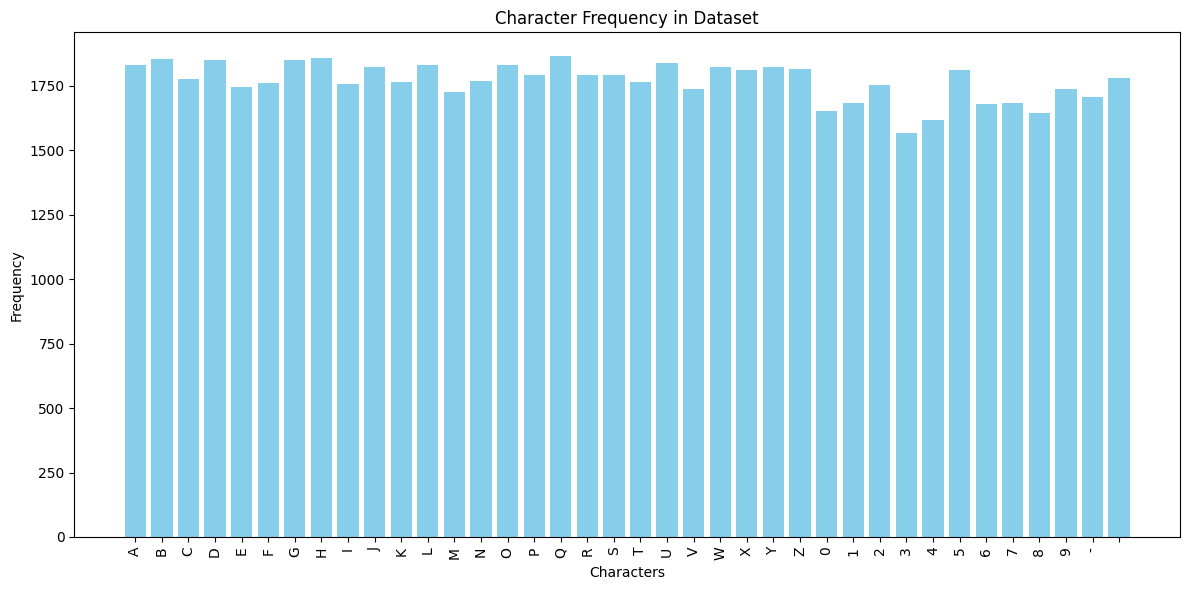

Total characters analyzed: 67172
Character frequencies: {'C': 1778, 'P': 1793, 'U': 1839, '5': 1811, 'D': 1848, 'T': 1764, 'R': 1790, 'B': 1852, '3': 1568, '6': 1678, '4': 1619, 'X': 1810, 'W': 1821, 'H': 1856, 'J': 1822, '0': 1652, 'L': 1829, 'I': 1756, 'O': 1832, '9': 1738, 'V': 1739, 'N': 1767, '1': 1682, 'K': 1764, 'S': 1792, 'E': 1744, '8': 1644, 'Y': 1822, ' ': 1781, 'Q': 1864, 'M': 1726, '-': 1705, '7': 1682, 'F': 1760, '2': 1752, 'G': 1848, 'Z': 1815, 'A': 1829}
Dataset generated! Images saved in '/kaggle/working/synthetic_data/images', labels in '/kaggle/working/synthetic_data/labels.txt'


[I 2025-05-07 10:25:25,328] A new study created in RDB with name: ocr_multiobjective


Cleaned /kaggle/working/synthetic_data/labels.txt: 0 labels modified, 0 labels removed.
Model configuration:
 {'cnn_layers': [{'type': 'conv', 'out_channels': 46, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.1058662096468555}, {'type': 'pool', 'kernel_size': 2, 'stride': 2}, {'type': 'conv', 'out_channels': 84, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.11084171740745956}, {'type': 'pool', 'kernel_size': 2, 'stride': 2}, {'type': 'conv', 'out_channels': 121, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'}, {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)}, {'type': 'conv', 'out_channels': 222, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'}, {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)}], 'rnn_type': 'lstm', 'rnn_layers': 3, 'hidden_size': 130, '

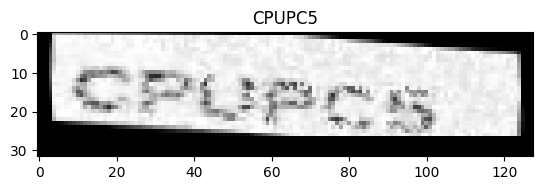

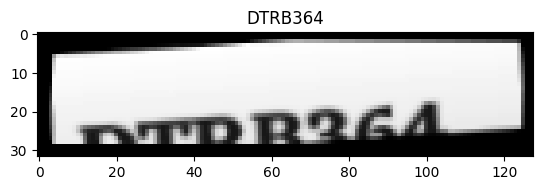

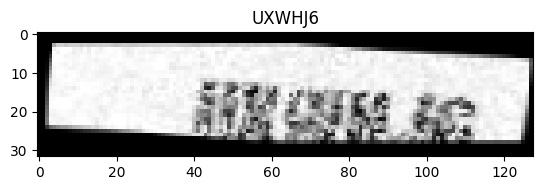

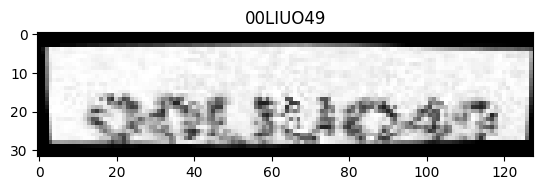

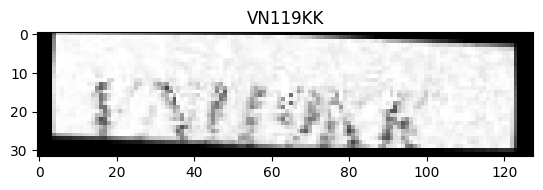

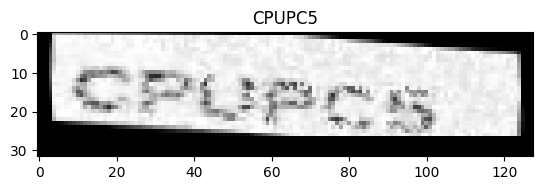

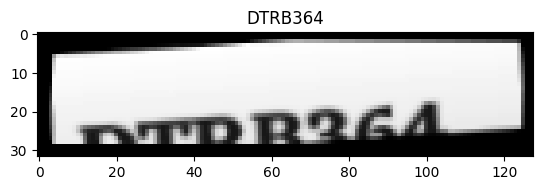

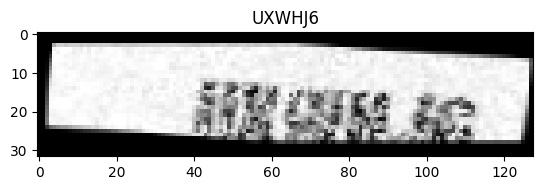

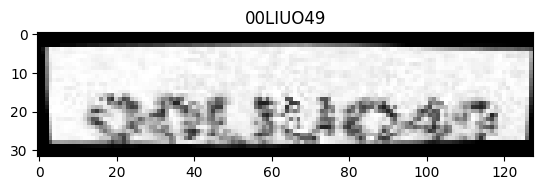

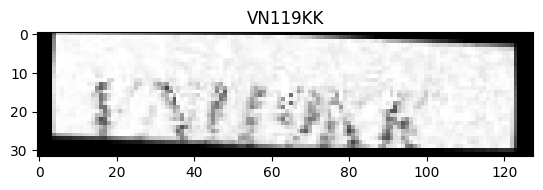

Epoch 1/5, Loss: 5.1832
Avg CER: 0.9979, Avg WER: 1.0031
Avg CER Probability: 0.4981, Avg WER Probability: 0.4872
Validation Loss: 13.2549
Validation CER: 0.9733, Validation WER: 0.9996
Validation CER Probability: 0.4583, Validation WER Probability: 0.4526
Harmonic mean: 0.9862931608841756
Epoch 2/5, Loss: 5.1813
Avg CER: 1.0014, Avg WER: 1.0037
Avg CER Probability: 0.4985, Avg WER Probability: 0.4868
Validation Loss: 13.2723
Validation CER: 0.9768, Validation WER: 0.9992
Validation CER Probability: 0.4624, Validation WER Probability: 0.4604
Harmonic mean: 0.9878800711083305
Epoch 3/5, Loss: 5.1843
Avg CER: 0.9968, Avg WER: 1.0027
Avg CER Probability: 0.4968, Avg WER Probability: 0.4857
Validation Loss: 13.2429
Validation CER: 0.9735, Validation WER: 0.9996
Validation CER Probability: 0.4827, Validation WER Probability: 0.4773
Harmonic mean: 0.9863568038920353
Epoch 4/5, Loss: 5.1803
Avg CER: 0.9950, Avg WER: 1.0025
Avg CER Probability: 0.4974, Avg WER Probability: 0.4857
Validation Lo

[I 2025-05-07 12:24:57,329] Trial 0 finished with values: [0.47272665256899027, 0.4657349072104782, 0.004830314588616602, 0.9876094137218815] and parameters: {'learning_rate': 5.247264590531333e-08, 'weight_decay': 0.12192627632426846, 'warmup_steps': 1741, 'temperature': 1.2098189409088973, 'ctc_entropy_weight': 0.779914943896037, 'ctc_label_smoothing': 0.17770211097876254, 'ctc_blank_penalty_weight': 0.310412938626599, 'bsd_beam_width': 10, 'bsd_blank_penalty': -0.1201728793032808, 'bsd_length_penalty': -0.18558820393281772, 'gradient_clipping_value': 2.249796313166586, 'gradient_norm_treshold': 295, 'cnn_out_channels_1': 46, 'cnn_dropout_1': 0.1058662096468555, 'cnn_out_channels_2': 84, 'cnn_dropout_2': 0.11084171740745956, 'cnn_out_channels_3': 121, 'cnn_out_channels_4': 222, 'rnn_layers': 3, 'hidden_size': 130, 'rnn_dropout': 0.11548641449642202}.


Validation Loss: 13.2335
Validation CER: 0.9763, Validation WER: 0.9992
Validation CER Probability: 0.4727, Validation WER Probability: 0.4657
Harmonic mean: 0.9876094137218815
Cleaned /kaggle/working/synthetic_data/labels.txt: 0 labels modified, 0 labels removed.
Model configuration:
 {'cnn_layers': [{'type': 'conv', 'out_channels': 33, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.14957632375155366}, {'type': 'pool', 'kernel_size': 2, 'stride': 2}, {'type': 'conv', 'out_channels': 44, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.11921216577875414}, {'type': 'pool', 'kernel_size': 2, 'stride': 2}, {'type': 'conv', 'out_channels': 119, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'}, {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)}, {'type': 'conv', 'out_channels': 213, 'kernel_size': 3, 'stride': 1, 'padding': 1, '

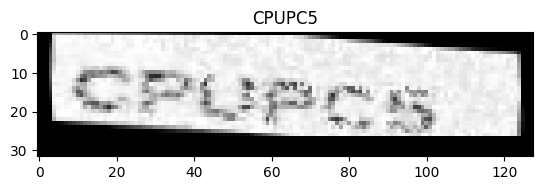

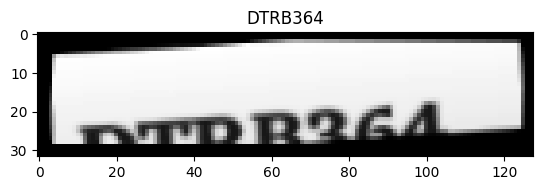

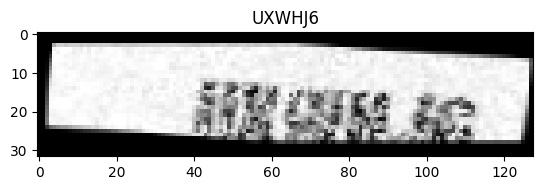

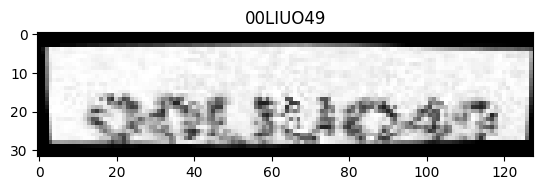

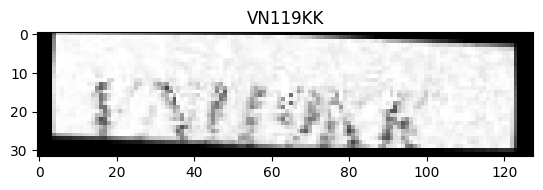

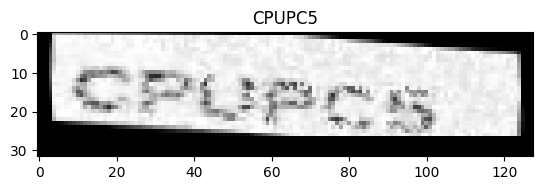

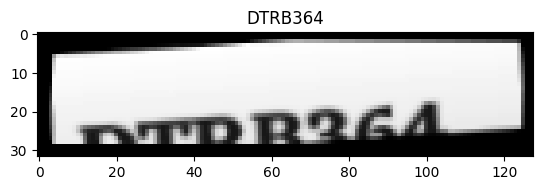

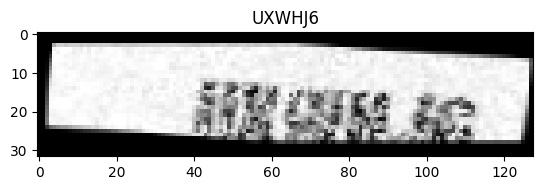

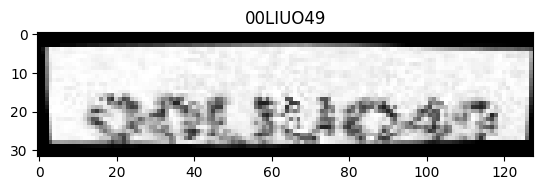

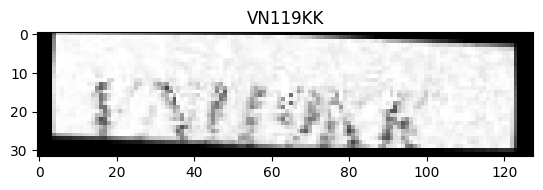

Epoch 1/5, Loss: 5.6301
Avg CER: 1.0141, Avg WER: 1.0206
Avg CER Probability: 0.6250, Avg WER Probability: 0.5960
Validation Loss: 13.5709
Validation CER: 0.9657, Validation WER: 1.0000
Validation CER Probability: 0.5124, Validation WER Probability: 0.5061
Harmonic mean: 0.9825731979218716
Epoch 2/5, Loss: 5.6397
Avg CER: 1.0116, Avg WER: 1.0188
Avg CER Probability: 0.6174, Avg WER Probability: 0.5885
Validation Loss: 13.6118
Validation CER: 0.9651, Validation WER: 1.0000
Validation CER Probability: 0.5101, Validation WER Probability: 0.5070
Harmonic mean: 0.9822558983344737
Epoch 3/5, Loss: 5.6501
Avg CER: 1.0156, Avg WER: 1.0194
Avg CER Probability: 0.6285, Avg WER Probability: 0.6000
Validation Loss: 13.5280
Validation CER: 0.9697, Validation WER: 0.9996
Validation CER Probability: 0.5411, Validation WER Probability: 0.5350
Harmonic mean: 0.9844098769145461
Epoch 4/5, Loss: 5.6359
Avg CER: 1.0122, Avg WER: 1.0189
Avg CER Probability: 0.6210, Avg WER Probability: 0.5913
Validation Lo

[I 2025-05-07 14:24:35,102] Trial 1 finished with values: [0.5399017340474204, 0.5344820268021261, 0.005123080393241252, 0.9847842467868071] and parameters: {'learning_rate': 1.4444937810037625e-08, 'weight_decay': 0.13945997940527424, 'warmup_steps': 1723, 'temperature': 1.1631424466374494, 'ctc_entropy_weight': 0.6376072961576758, 'ctc_label_smoothing': 0.16842270819273886, 'ctc_blank_penalty_weight': 0.23217674462515803, 'bsd_beam_width': 10, 'bsd_blank_penalty': -0.12326415291082268, 'bsd_length_penalty': -0.17868989632095705, 'gradient_clipping_value': 7.467783664402534, 'gradient_norm_treshold': 267, 'cnn_out_channels_1': 33, 'cnn_dropout_1': 0.14957632375155366, 'cnn_out_channels_2': 44, 'cnn_dropout_2': 0.11921216577875414, 'cnn_out_channels_3': 119, 'cnn_out_channels_4': 213, 'rnn_layers': 3, 'hidden_size': 221, 'rnn_dropout': 0.18450673747456786}.


Validation Loss: 13.6450
Validation CER: 0.9700, Validation WER: 1.0000
Validation CER Probability: 0.5399, Validation WER Probability: 0.5345
Harmonic mean: 0.9847842467868071
Cleaned /kaggle/working/synthetic_data/labels.txt: 0 labels modified, 0 labels removed.
Model configuration:
 {'cnn_layers': [{'type': 'conv', 'out_channels': 25, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.1418869192247181}, {'type': 'pool', 'kernel_size': 2, 'stride': 2}, {'type': 'conv', 'out_channels': 57, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu', 'dropout': 0.1302604832706498}, {'type': 'pool', 'kernel_size': 2, 'stride': 2}, {'type': 'conv', 'out_channels': 133, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'batchnorm': True, 'activation': 'relu'}, {'type': 'pool', 'kernel_size': (2, 2), 'stride': (2, 1), 'padding': (0, 1)}, {'type': 'conv', 'out_channels': 271, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'ba

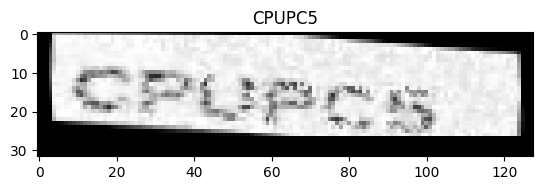

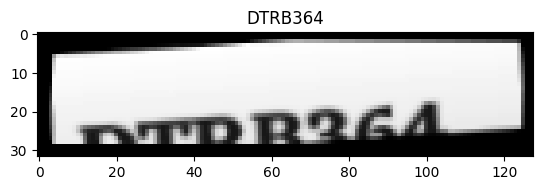

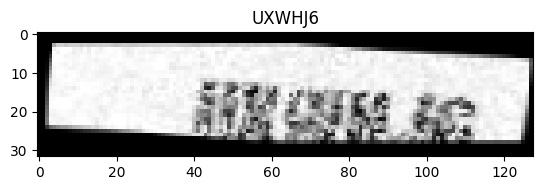

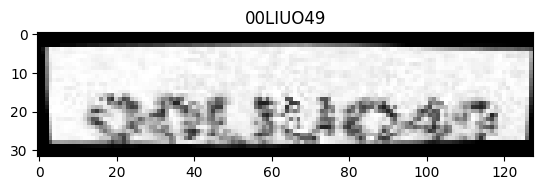

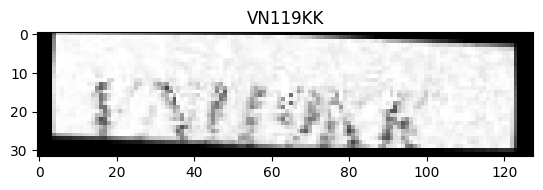

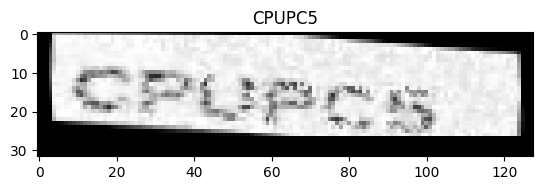

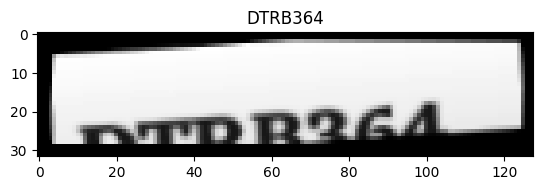

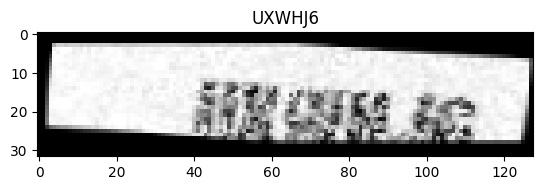

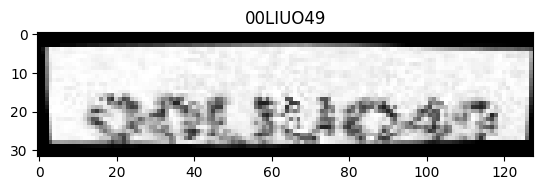

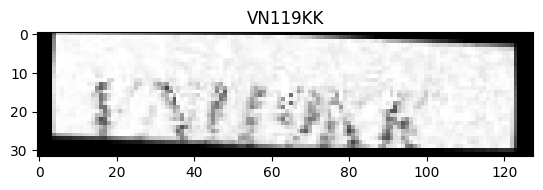

Epoch 1/5, Loss: 5.4951
Avg CER: 1.0572, Avg WER: 1.0000
Avg CER Probability: 0.7140, Avg WER Probability: 0.6866
Validation Loss: 13.4525
Validation CER: 1.0392, Validation WER: 1.0000
Validation CER Probability: 0.7581, Validation WER Probability: 0.7298
Harmonic mean: 1.019215654058124
Epoch 2/5, Loss: 5.4958
Avg CER: 1.0568, Avg WER: 1.0000
Avg CER Probability: 0.7146, Avg WER Probability: 0.6861
Validation Loss: 13.4713
Validation CER: 1.0475, Validation WER: 1.0000
Validation CER Probability: 0.7644, Validation WER Probability: 0.7411
Harmonic mean: 1.023222809421807
Epoch 3/5, Loss: 5.4729
Avg CER: 1.0582, Avg WER: 1.0000
Avg CER Probability: 0.7084, Avg WER Probability: 0.6829
Validation Loss: 13.4636
Validation CER: 1.0388, Validation WER: 1.0000
Validation CER Probability: 0.7530, Validation WER Probability: 0.7261
Harmonic mean: 1.0190139060243122
Epoch 4/5, Loss: 5.5108
Avg CER: 1.0617, Avg WER: 0.9999
Avg CER Probability: 0.7186, Avg WER Probability: 0.6914
Validation Loss

[I 2025-05-07 16:37:04,204] Trial 2 finished with values: [0.7607837014378512, 0.7300751594340835, 0.005100347062398214, 1.0209877669643987] and parameters: {'learning_rate': 3.424284549339603e-08, 'weight_decay': 0.13711670372514614, 'warmup_steps': 1286, 'temperature': 1.1450014965126298, 'ctc_entropy_weight': 0.6844623225744345, 'ctc_label_smoothing': 0.16156006486038924, 'ctc_blank_penalty_weight': 0.3880721229845745, 'bsd_beam_width': 11, 'bsd_blank_penalty': -0.131341507904755, 'bsd_length_penalty': -0.19481263653446265, 'gradient_clipping_value': 5.497601827599183, 'gradient_norm_treshold': 229, 'cnn_out_channels_1': 25, 'cnn_dropout_1': 0.1418869192247181, 'cnn_out_channels_2': 57, 'cnn_dropout_2': 0.1302604832706498, 'cnn_out_channels_3': 133, 'cnn_out_channels_4': 271, 'rnn_layers': 2, 'hidden_size': 142, 'rnn_dropout': 0.13933198773875466}.


Validation Loss: 13.4487
Validation CER: 1.0429, Validation WER: 1.0000
Validation CER Probability: 0.7608, Validation WER Probability: 0.7301
Harmonic mean: 1.0209877669643987
Starting Optuna Dashboard with storage: /kaggle/working/optuna/optuna_study.db


In [53]:
if __name__ == "__main__":
    # Synthetic data generation (same as originally)
    if not font_files:
        print("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
        main_logger.error("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
    else:
        create_synthetic_dataset(NUM_SAMPLES)
        main_logger.info("Synthetic dataset generated.")

    # Path to Optuna database
    storage_path = os.path.join(OPTUNA_DIR, 'optuna_study.db')
    storage = f"sqlite:///{storage_path}"
    main_logger.info(f"Optuna database set at {storage_path}")

    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not FINAL_TRAINING:
        # Multi-objective study
        study = optuna.create_study(
            directions=["minimize", "minimize", "minimize", "maximize"],  # Validation loss, grad_norm, blank_probs
            storage=storage,
            study_name="ocr_multiobjective",
            load_if_exists=True
        )
        main_logger.info("Set & Run Optuna optimalization.")
        study.optimize(objective, n_trials=NUMBER_OF_OPTUNA_TRIALS) # You can adjust the number of trials

        # Log best trials (Pareto front)
        #print("Best trials (Pareto front):")
        main_logger.info("Best trials (Pareto front):")
        for trial in study.best_trials:
            #print(f"  Trial {trial.number}:")
            main_logger.debug(f"Trial {trial.number}:")
            #print(f"    Values: val_loss={trial.values[0]}, grad_norm={trial.values[1]}, blank_probs={trial.values[2]}")
            main_logger.debug(f"Values: val_loss={trial.values[0]}, grad_norm={trial.values[1]}, blank_probs={trial.values[2]}")
            #print(f"    Params: {trial.params}")
            main_logger.debug(f"Params: {trial.params}")

        # Running Optuna Dashboard in the background
        dashboard_thread = threading.Thread(target=run_optuna_dashboard, args=(storage_path,))
        dashboard_thread.start()
    else:
        # Load study for final training
        study = optuna.load_study(study_name="ocr_multiobjective", storage=storage)
        main_logger.info("Loaded Optuna study for final training.")

        best_trial = min(study.best_trials, key=balance_metric)
        main_logger.info(f"Selected best trial {best_trial.number} for final training:")
        main_logger.info(f"  Values: val_loss={best_trial.values[0]}, grad_norm={best_trial.values[1]}, blank_probs={best_trial.values[2]}, harmonic_mean={best_trial.values[3]}")
        main_logger.info(f"  User attrs: val_cer={best_trial.user_attrs.get('val_cer')}, val_wer={best_trial.user_attrs.get('val_wer')}")
        main_logger.info(f"  Params: {best_trial.params}")

        # Construct config_model from best trial parameters
        config_model = construct_config_model(best_trial.params)

        # Load dataset
        full_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
        main_logger.info("Loaded dataset for final training.")

        # Run final training
        best_val_loss, final_val_cer, final_val_wer, final_harmonic_mean = train(
            full_dataset=full_dataset,
            device=device,
            config_model=config_model,
            pretrained_model_path=pretrained_model_path if os.path.exists(pretrained_model_path) else None,
            num_epochs=FINAL_EPOCHS,
            learning_rate=best_trial.params['learning_rate'],
            weight_decay=best_trial.params['weight_decay'],
            warmup_steps=best_trial.params['warmup_steps'],
            temperature=best_trial.params['temperature'],
            ctc_entropy_weight=best_trial.params['ctc_entropy_weight'],
            ctc_label_smoothing=best_trial.params['ctc_label_smoothing'],
            ctc_blank_penalty_weight=best_trial.params['ctc_blank_penalty_weight'],
            bsd_beam_width=best_trial.params['bsd_beam_width'],
            bsd_blank_penalty=best_trial.params['bsd_blank_penalty'],
            bsd_length_penalty=best_trial.params['bsd_length_penalty'],
            gradient_clipping_value=best_trial.params['gradient_clipping_value'],
            gradient_norm_threshold=best_trial.params['gradient_norm_treshold']
        )
        main_logger.info(
            f"Final training completed: "
            f"Best Validation Loss: {best_val_loss:.4f}, "
            f"Final Validation CER: {final_val_cer:.4f}, "
            f"Final Validation WER: {final_val_wer:.4f}, "
            f"Final Harmonic Mean: {final_harmonic_mean:.4f}"
        )

    # Close the file after logging is complete
    rotating_json_file_handler.close()

## **<font style="color:blue">Check final ONNX model</font>**
-------------------

In [54]:
# Load ONNX model
if FINAL_TRAINING:
    onnx_model = onnx.load(os.path.join(MODEL_DIR, 'final_ocr_model_final.onnx'))
    onnx.checker.check_model(onnx_model)
    print("ONNX model is valid")

In [55]:
# Run inference
if FINAL_TRAINING:
    ort_session = ort.InferenceSession(os.path.join(MODEL_DIR, 'final_ocr_model_final.onnx'))
    sample_input = np.random.randn(1, 1, IMG_HEIGHT, IMG_WIDTH).astype(np.float32)
    outputs = ort_session.run(None, {'input': sample_input})
    print("ONNX inference successful, output shape:", outputs[0].shape)

## **<font style="color:blue">Download results</font>**
-------------------

In [56]:
def zip_folder_with_shutil(source_folder, output_path):
    '''Function for zip dir data'''
    shutil.make_archive(output_path, 'zip', source_folder)

In [57]:
zip_folder_with_shutil('/kaggle/working/backgrounds', '/kaggle/working/backgrounds')
zip_folder_with_shutil('/kaggle/working/synthetic_data', '/kaggle/working/synthetic_data')
zip_folder_with_shutil('/kaggle/working/model_dir', '/kaggle/working/model_dir')
zip_folder_with_shutil('/kaggle/working/runs', '/kaggle/working/runs')
zip_folder_with_shutil('/kaggle/working/optuna', '/kaggle/working/optuna')
zip_folder_with_shutil('/kaggle/working/logs', '/kaggle/working/logs')

In [58]:
#!tensorboard --logdir=/kaggle/working/runs --port 6006
#!optuna-dashboard sqlite:///kaggle/working/optuna/optuna_study.db